This is an analysis of the Fisker stock price. The goal is to predict the future price target.  Fisker Inc. is an American electric vehicle automaker founded by Henrik Fisker. Launched in 2016 and based in Southern California, Fisker Inc. is the relaunch of the Fisker brand previously known as Fisker Automotive, which produced the Fisker Karma.https://www.reddit.com/r/FiskerInvestorsClub/

In [56]:
import warnings
import os, sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from pmdarima import auto_arima
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from timeit import default_timer as timer
warnings.filterwarnings("ignore")



In [57]:
os.getcwd()

'/Users/chriskehl/Library/Mobile Documents/com~apple~CloudDocs/data_files/timeSeries'

In [58]:
os.chdir('/Users/chriskehl/Library/Mobile Documents/com~apple~CloudDocs/data_files/timeSeries')

In [59]:
os.getcwd()

'/Users/chriskehl/Library/Mobile Documents/com~apple~CloudDocs/data_files/timeSeries'

In [60]:
# Download Fisker stock
data = yf.download('FSR','2020-07-01','2021-03-15')

[*********************100%***********************]  1 of 1 completed


In [61]:
# View of the first few trading days of Fisker stock (FSR) 
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-01,10.80,10.80,10.68,10.71,10.71,577300
2020-07-02,10.79,10.88,10.68,10.85,10.85,842600
2020-07-06,11.00,11.08,10.91,10.93,10.93,1358300
2020-07-07,10.95,10.95,10.65,10.71,10.71,862700
2020-07-08,10.70,10.81,10.63,10.81,10.81,1485200


In [62]:
# Look at the last few days of Fisker stock (FSR) 
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-08,22.799999,23.570000,21.520000,21.740000,21.740000,13902800
2021-03-09,23.280001,23.690001,21.910000,22.180000,22.180000,17995700
2021-03-10,23.190001,25.370001,22.910000,24.440001,24.440001,21338000
2021-03-11,25.219999,25.330000,23.770000,24.480000,24.480000,12343400
2021-03-12,23.379999,23.950001,22.610001,23.000000,23.000000,9611900


Fisker daily closing price chart.

<AxesSubplot:title={'center':'Fisker Closing Price'}, xlabel='Date'>

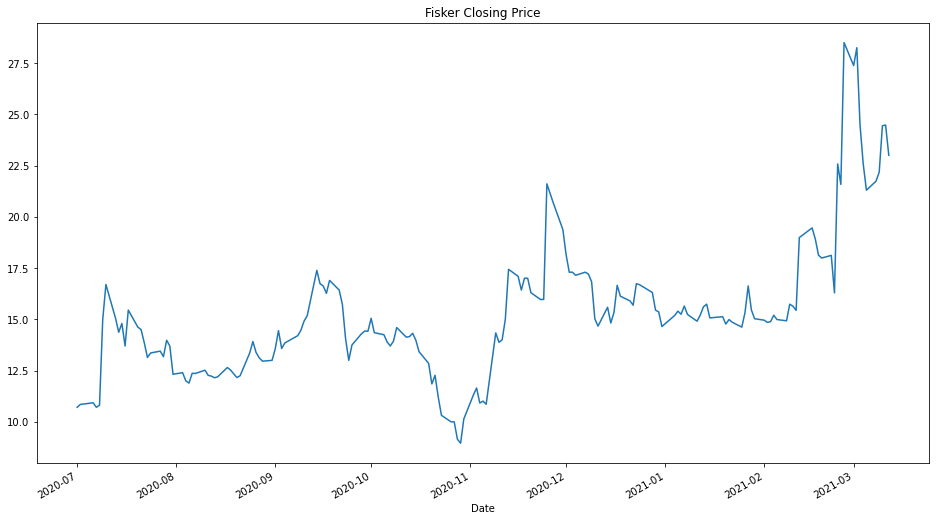

In [63]:
data['Close'].plot(label='FSR', figsize=(16,9), title='Fisker Closing Price')

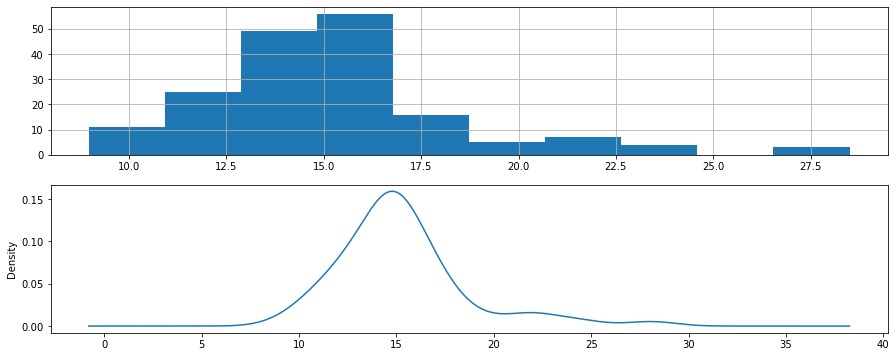

In [64]:
# Histogram of the closing price

plt.figure(1, figsize=(15,6))
plt.subplot(211)
data["Close"].hist()
plt.subplot(212)
data["Close"].plot(kind='kde')
plt.show()

Using the histogram we can view how many times during a period the stock price closes at a certain price.  We can use this method to find a buy-in and sell price target for the Fisker stock.

In [68]:
# Download Fisker stock
fsr30Days = yf.download('FSR','2021-02-11','2021-03-10')

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Fisker Closing Price'}, xlabel='Date'>

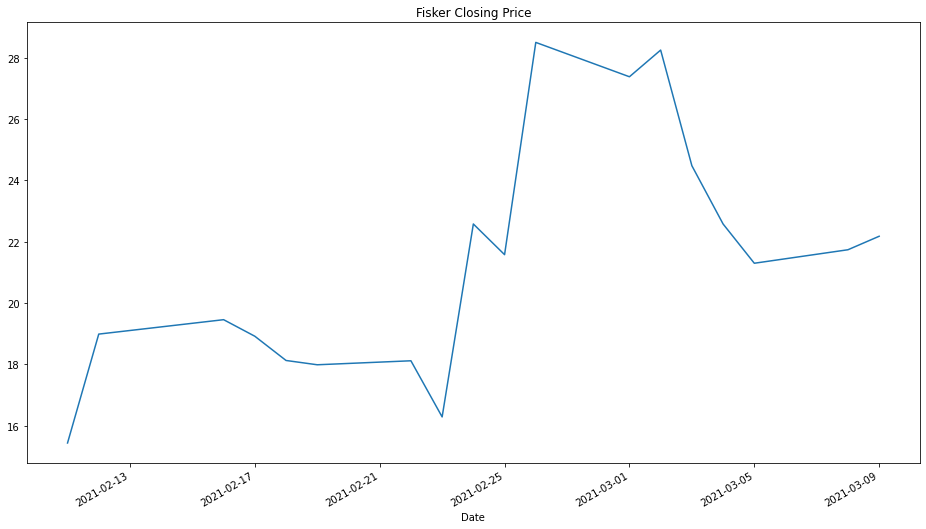

In [71]:
fsr30Days['Close'].plot(label='FSR', figsize=(16,9), title='Fisker Closing Price')
#plt.savefig('30dayFsrPlot.png', transparent=True)

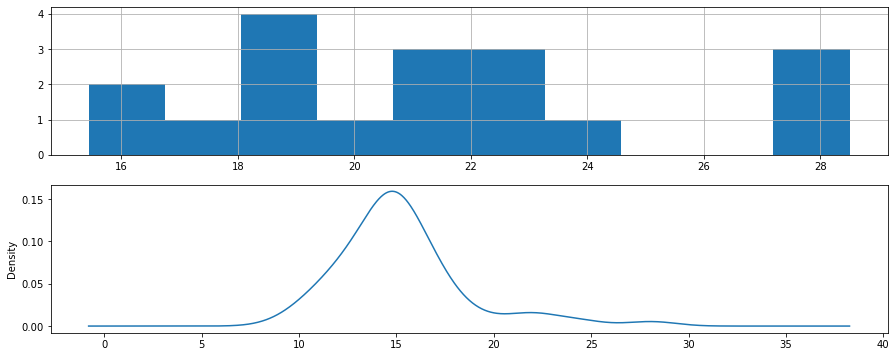

<Figure size 1152x648 with 0 Axes>

In [70]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
fsr30Days["Close"].hist()
plt.subplot(212)
data["Close"].plot(kind='kde')
plt.show()
#plt.savefig('30dayFsrHist.jpg', transparent=True)

We use the seasonal_decompose method to check for seasonality in the stock data.

<Figure size 1152x648 with 0 Axes>

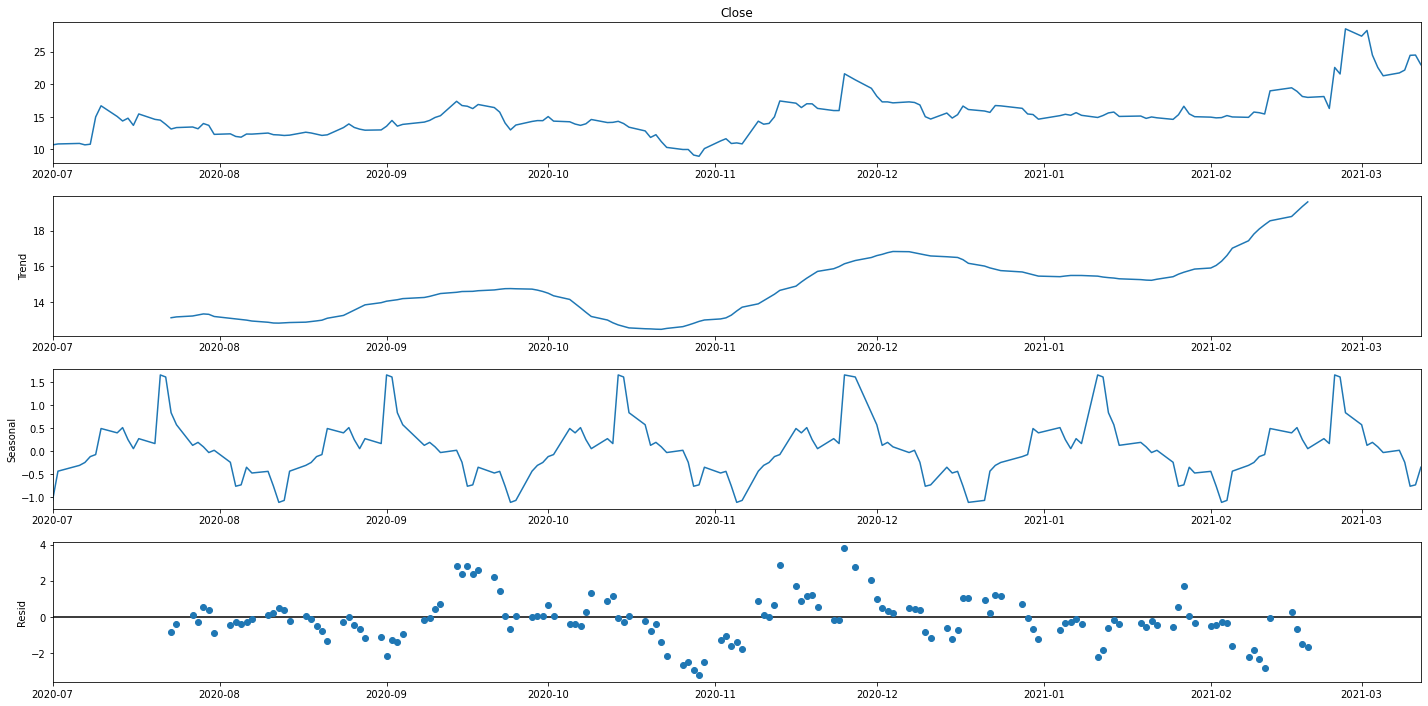

In [72]:
# test for seasonality
# Checking decomposition of trend, seasonality and residue of the original time seires.
decomposition = seasonal_decompose(data['Close'], model='additive', period=30)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)
plt.savefig('30dayDecomposition.png', transparent=True)

Use Smoothing Methods. The process of smoothing is a statistical method is used to create an approximation function to remove irregularities in data and attempt to capture significant patterns. 
Smoothing techniques utilize the weighted averages of a previous observation to forecast a new value

In [73]:
# Our timeSeries model will only be done on the closing column.
# The training set will have all the data expected for the last 30 days
# The the test contains only the last 30 days to evaluate against predictions.
train = data.Close[0:-30]
test = data.Close[-30:]

In [74]:
train.head()

Date
2020-07-01    10.71
2020-07-02    10.85
2020-07-06    10.93
2020-07-07    10.71
2020-07-08    10.81
Name: Close, dtype: float64

In [75]:
test.head()

Date
2021-01-29    15.03
2021-02-01    14.96
2021-02-02    14.85
2021-02-03    14.89
2021-02-04    15.20
Name: Close, dtype: float64

There are three algorithms commonly used for smoothing which are Simple Simple Exponential Smoothing, Double Exponential Smoothing (AKA Holt's exponential), and Triple Exponential Smothing. Since our data has trends we will perform only the Double and Triple Exponential smoothing algorithms. Simple Exponentual Smoothing works well when then are no trends or seasonality.

In [76]:
# Find the best smoothing parameter ranging from 0 - 1
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred)/ y_true)) *100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [77]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [78]:
param_grid = {'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damping_slope': [0.10, 0.20, 0.30, 0.50, 0.60, 0.70, 0.80, 0.90],
              'damped': [True, False]}
pg = list(ParameterGrid(param_grid))
    

In [79]:
df_results_moni = pd.DataFrame(columns=['smoothing_level', 'smoothing_slope',
                                    'damping_slope', 'damped', 'RSME', 'r2'])
start = timer()

for a,b in enumerate(pg):
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    print(smoothing_level, smoothing_slope, damping_slope, damped)
    fit1 = Holt(train, damped = damped).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope,damping_slope=damping_slope, optimized=False)
    #fit1.summary
    z = fit1.forecast(30)
    print(z)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    print( f' RMSE is {np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))}')
    df_results_moni = df_results_moni.append({'smoothing_level':smoothing_level,
                                             'smoothing_slope':smoothing_slope,
                                             'damping_slope':damping_slope, 
                                             'damped':damped,
                                             'RMSE':RMSE, 'r2':r2}, ignore_index=True)
    end = timer()
    print(f' Total time taken to complete grid search in seconds:{(end - start)}')
          
    print(f' Below mentioned parameter gives least RMSE and r2')
    df_results_moni.sort_values(by=['RMSE','r2']).head(1)

0.1 0.1 0.1 True
146    15.406750
147    15.406770
148    15.406772
149    15.406772
150    15.406772
151    15.406772
152    15.406772
153    15.406772
154    15.406772
155    15.406772
156    15.406772
157    15.406772
158    15.406772
159    15.406772
160    15.406772
161    15.406772
162    15.406772
163    15.406772
164    15.406772
165    15.406772
166    15.406772
167    15.406772
168    15.406772
169    15.406772
170    15.406772
171    15.406772
172    15.406772
173    15.406772
174    15.406772
175    15.406772
dtype: float64
 RMSE is 6.08481398225672
 Total time taken to complete grid search in seconds:0.02113785200072016
 Below mentioned parameter gives least RMSE and r2
0.1 0.2 0.1 True
146    15.405130
147    15.405169
148    15.405173
149    15.405174
150    15.405174
151    15.405174
152    15.405174
153    15.405174
154    15.405174
155    15.405174
156    15.405174
157    15.405174
158    15.405174
159    15.405174
160    15.405174
161    15.405174
162    15.405174
16

dtype: float64
 RMSE is 6.010970427897705
 Total time taken to complete grid search in seconds:0.44331147000048077
 Below mentioned parameter gives least RMSE and r2
0.3 0.6 0.1 True
146    15.514428
147    15.514589
148    15.514605
149    15.514606
150    15.514607
151    15.514607
152    15.514607
153    15.514607
154    15.514607
155    15.514607
156    15.514607
157    15.514607
158    15.514607
159    15.514607
160    15.514607
161    15.514607
162    15.514607
163    15.514607
164    15.514607
165    15.514607
166    15.514607
167    15.514607
168    15.514607
169    15.514607
170    15.514607
171    15.514607
172    15.514607
173    15.514607
174    15.514607
175    15.514607
dtype: float64
 RMSE is 6.00858090786625
 Total time taken to complete grid search in seconds:0.461390935000054
 Below mentioned parameter gives least RMSE and r2
0.3 0.7 0.1 True
146    15.517802
147    15.517980
148    15.517997
149    15.517999
150    15.517999
151    15.517999
152    15.517999
153    1

dtype: float64
 RMSE is 5.900045157451465
 Total time taken to complete grid search in seconds:0.880076616000224
 Below mentioned parameter gives least RMSE and r2
0.5 0.8 0.1 True
146    15.674392
147    15.673233
148    15.673117
149    15.673105
150    15.673104
151    15.673104
152    15.673104
153    15.673104
154    15.673104
155    15.673104
156    15.673104
157    15.673104
158    15.673104
159    15.673104
160    15.673104
161    15.673104
162    15.673104
163    15.673104
164    15.673104
165    15.673104
166    15.673104
167    15.673104
168    15.673104
169    15.673104
170    15.673104
171    15.673104
172    15.673104
173    15.673104
174    15.673104
175    15.673104
dtype: float64
 RMSE is 5.8983293109981005
 Total time taken to complete grid search in seconds:0.8984730580004907
 Below mentioned parameter gives least RMSE and r2
0.5 0.9 0.1 True
146    15.676991
147    15.675645
148    15.675511
149    15.675497
150    15.675496
151    15.675496
152    15.675496
153    

146    15.673934
147    15.672206
148    15.672033
149    15.672016
150    15.672014
151    15.672014
152    15.672014
153    15.672014
154    15.672014
155    15.672014
156    15.672014
157    15.672014
158    15.672014
159    15.672014
160    15.672014
161    15.672014
162    15.672014
163    15.672014
164    15.672014
165    15.672014
166    15.672014
167    15.672014
168    15.672014
169    15.672014
170    15.672014
171    15.672014
172    15.672014
173    15.672014
174    15.672014
175    15.672014
dtype: float64
 RMSE is 5.899082497806791
 Total time taken to complete grid search in seconds:1.3326366070004951
 Below mentioned parameter gives least RMSE and r2
0.7 0.5 0.1 True
146    15.672712
147    15.670510
148    15.670289
149    15.670267
150    15.670265
151    15.670265
152    15.670265
153    15.670265
154    15.670265
155    15.670265
156    15.670265
157    15.670265
158    15.670265
159    15.670265
160    15.670265
161    15.670265
162    15.670265
163    15.670265
16

 RMSE is 5.991217989456389
 Total time taken to complete grid search in seconds:1.7723332820005453
 Below mentioned parameter gives least RMSE and r2
0.9 0.4 0.1 True
146    15.534607
147    15.531205
148    15.530865
149    15.530831
150    15.530828
151    15.530827
152    15.530827
153    15.530827
154    15.530827
155    15.530827
156    15.530827
157    15.530827
158    15.530827
159    15.530827
160    15.530827
161    15.530827
162    15.530827
163    15.530827
164    15.530827
165    15.530827
166    15.530827
167    15.530827
168    15.530827
169    15.530827
170    15.530827
171    15.530827
172    15.530827
173    15.530827
174    15.530827
175    15.530827
dtype: float64
 RMSE is 5.997210338805052
 Total time taken to complete grid search in seconds:1.7935307470006592
 Below mentioned parameter gives least RMSE and r2
0.9 0.5 0.1 True
146    15.526794
147    15.522480
148    15.522048
149    15.522005
150    15.522001
151    15.522000
152    15.522000
153    15.522000
154  

 RMSE is 6.097116896420419
 Total time taken to complete grid search in seconds:1.978786604000561
 Below mentioned parameter gives least RMSE and r2
0.1 0.7 0.2 True
146    15.385841
147    15.386880
148    15.387088
149    15.387130
150    15.387138
151    15.387140
152    15.387140
153    15.387140
154    15.387140
155    15.387140
156    15.387140
157    15.387140
158    15.387140
159    15.387140
160    15.387140
161    15.387140
162    15.387140
163    15.387140
164    15.387140
165    15.387140
166    15.387140
167    15.387140
168    15.387140
169    15.387140
170    15.387140
171    15.387140
172    15.387140
173    15.387140
174    15.387140
175    15.387140
dtype: float64
 RMSE is 6.098791552388174
 Total time taken to complete grid search in seconds:1.9975378120007008
 Below mentioned parameter gives least RMSE and r2
0.1 0.8 0.2 True
146    15.383515
147    15.384720
148    15.384961
149    15.385009
150    15.385019
151    15.385021
152    15.385021
153    15.385021
154   

146    15.540051
147    15.541746
148    15.542086
149    15.542153
150    15.542167
151    15.542170
152    15.542170
153    15.542170
154    15.542170
155    15.542170
156    15.542170
157    15.542170
158    15.542170
159    15.542170
160    15.542170
161    15.542170
162    15.542170
163    15.542170
164    15.542170
165    15.542170
166    15.542170
167    15.542170
168    15.542170
169    15.542170
170    15.542170
171    15.542170
172    15.542170
173    15.542170
174    15.542170
175    15.542170
dtype: float64
 RMSE is 5.989243670334525
 Total time taken to complete grid search in seconds:2.40223931500077
 Below mentioned parameter gives least RMSE and r2
0.3 0.7 0.2 True
146    15.547705
147    15.549608
148    15.549988
149    15.550064
150    15.550079
151    15.550083
152    15.550083
153    15.550083
154    15.550083
155    15.550083
156    15.550083
157    15.550083
158    15.550083
159    15.550083
160    15.550083
161    15.550083
162    15.550083
163    15.550083
164 

dtype: float64
 RMSE is 5.881656324113445
 Total time taken to complete grid search in seconds:2.8372332290000486
 Below mentioned parameter gives least RMSE and r2
0.6 0.5 0.2 True
146    15.704600
147    15.700557
148    15.699749
149    15.699587
150    15.699555
151    15.699549
152    15.699547
153    15.699547
154    15.699547
155    15.699547
156    15.699547
157    15.699547
158    15.699547
159    15.699547
160    15.699547
161    15.699547
162    15.699547
163    15.699547
164    15.699547
165    15.699547
166    15.699547
167    15.699547
168    15.699547
169    15.699547
170    15.699547
171    15.699547
172    15.699547
173    15.699547
174    15.699547
175    15.699547
dtype: float64
 RMSE is 5.88016827327316
 Total time taken to complete grid search in seconds:2.8539655700005824
 Below mentioned parameter gives least RMSE and r2
0.6 0.6 0.2 True
146    15.707498
147    15.702327
148    15.701292
149    15.701086
150    15.701044
151    15.701036
152    15.701034
153    1

dtype: float64
 RMSE is 5.914467972634446
 Total time taken to complete grid search in seconds:3.047930821000591
 Below mentioned parameter gives least RMSE and r2
0.7 0.9 0.2 True
146    15.662128
147    15.646284
148    15.643115
149    15.642481
150    15.642354
151    15.642329
152    15.642324
153    15.642323
154    15.642323
155    15.642323
156    15.642323
157    15.642323
158    15.642323
159    15.642323
160    15.642323
161    15.642323
162    15.642323
163    15.642323
164    15.642323
165    15.642323
166    15.642323
167    15.642323
168    15.642323
169    15.642323
170    15.642323
171    15.642323
172    15.642323
173    15.642323
174    15.642323
175    15.642323
dtype: float64
 RMSE is 5.919654341462114
 Total time taken to complete grid search in seconds:3.068539038000381
 Below mentioned parameter gives least RMSE and r2
0.8 0.1 0.2 True
146    15.632409
147    15.630484
148    15.630100
149    15.630023
150    15.630007
151    15.630004
152    15.630004
153    15

146    15.379758
147    15.382088
148    15.382787
149    15.382997
150    15.383060
151    15.383079
152    15.383084
153    15.383086
154    15.383087
155    15.383087
156    15.383087
157    15.383087
158    15.383087
159    15.383087
160    15.383087
161    15.383087
162    15.383087
163    15.383087
164    15.383087
165    15.383087
166    15.383087
167    15.383087
168    15.383087
169    15.383087
170    15.383087
171    15.383087
172    15.383087
173    15.383087
174    15.383087
175    15.383087
dtype: float64
 RMSE is 6.101675602770143
 Total time taken to complete grid search in seconds:3.4712755710006604
 Below mentioned parameter gives least RMSE and r2
0.1 0.6 0.3 True
146    15.376005
147    15.378863
148    15.379720
149    15.379977
150    15.380054
151    15.380078
152    15.380085
153    15.380087
154    15.380087
155    15.380087
156    15.380087
157    15.380087
158    15.380088
159    15.380088
160    15.380088
161    15.380088
162    15.380088
163    15.380088
16

146    15.609831
147    15.618300
148    15.620840
149    15.621602
150    15.621831
151    15.621899
152    15.621920
153    15.621926
154    15.621928
155    15.621929
156    15.621929
157    15.621929
158    15.621929
159    15.621929
160    15.621929
161    15.621929
162    15.621929
163    15.621929
164    15.621929
165    15.621929
166    15.621929
167    15.621929
168    15.621929
169    15.621929
170    15.621929
171    15.621929
172    15.621929
173    15.621929
174    15.621929
175    15.621929
dtype: float64
 RMSE is 5.933624908658469
 Total time taken to complete grid search in seconds:3.9007389130001684
 Below mentioned parameter gives least RMSE and r2
0.4 0.1 0.3 True
146    15.600604
147    15.601639
148    15.601950
149    15.602043
150    15.602071
151    15.602080
152    15.602082
153    15.602083
154    15.602083
155    15.602083
156    15.602083
157    15.602083
158    15.602083
159    15.602083
160    15.602083
161    15.602083
162    15.602083
163    15.602083
16

 Total time taken to complete grid search in seconds:4.102386158000627
 Below mentioned parameter gives least RMSE and r2
0.5 0.4 0.3 True
146    15.706612
147    15.707024
148    15.707148
149    15.707185
150    15.707196
151    15.707199
152    15.707200
153    15.707201
154    15.707201
155    15.707201
156    15.707201
157    15.707201
158    15.707201
159    15.707201
160    15.707201
161    15.707201
162    15.707201
163    15.707201
164    15.707201
165    15.707201
166    15.707201
167    15.707201
168    15.707201
169    15.707201
170    15.707201
171    15.707201
172    15.707201
173    15.707201
174    15.707201
175    15.707201
dtype: float64
 RMSE is 5.8748897232724175
 Total time taken to complete grid search in seconds:4.120367929000167
 Below mentioned parameter gives least RMSE and r2
0.5 0.5 0.3 True
146    15.718753
147    15.718627
148    15.718590
149    15.718578
150    15.718575
151    15.718574
152    15.718574
153    15.718573
154    15.718573
155    15.718573

 RMSE is 5.9360410952872495
 Total time taken to complete grid search in seconds:4.515573355000015
 Below mentioned parameter gives least RMSE and r2
0.8 0.1 0.3 True
146    15.634166
147    15.630951
148    15.629986
149    15.629697
150    15.629610
151    15.629584
152    15.629577
153    15.629574
154    15.629573
155    15.629573
156    15.629573
157    15.629573
158    15.629573
159    15.629573
160    15.629573
161    15.629573
162    15.629573
163    15.629573
164    15.629573
165    15.629573
166    15.629573
167    15.629573
168    15.629573
169    15.629573
170    15.629573
171    15.629573
172    15.629573
173    15.629573
174    15.629573
175    15.629573
dtype: float64
 RMSE is 5.9284111045895855
 Total time taken to complete grid search in seconds:4.535435051000604
 Below mentioned parameter gives least RMSE and r2
0.8 0.2 0.3 True
146    15.629427
147    15.622372
148    15.620256
149    15.619621
150    15.619430
151    15.619373
152    15.619356
153    15.619351
154  

 Total time taken to complete grid search in seconds:4.929494439000337
 Below mentioned parameter gives least RMSE and r2
0.1 0.4 0.5 True
146    15.353519
147    15.361528
148    15.365533
149    15.367535
150    15.368536
151    15.369036
152    15.369287
153    15.369412
154    15.369474
155    15.369506
156    15.369521
157    15.369529
158    15.369533
159    15.369535
160    15.369536
161    15.369537
162    15.369537
163    15.369537
164    15.369537
165    15.369537
166    15.369537
167    15.369537
168    15.369537
169    15.369537
170    15.369537
171    15.369537
172    15.369537
173    15.369537
174    15.369537
175    15.369537
dtype: float64
 RMSE is 6.11129301910301
 Total time taken to complete grid search in seconds:4.9493800099999135
 Below mentioned parameter gives least RMSE and r2
0.1 0.5 0.5 True
146    15.348016
147    15.358442
148    15.363655
149    15.366261
150    15.367564
151    15.368216
152    15.368542
153    15.368705
154    15.368786
155    15.368827


146    15.649189
147    15.681641
148    15.697868
149    15.705981
150    15.710037
151    15.712066
152    15.713080
153    15.713587
154    15.713840
155    15.713967
156    15.714031
157    15.714062
158    15.714078
159    15.714086
160    15.714090
161    15.714092
162    15.714093
163    15.714093
164    15.714094
165    15.714094
166    15.714094
167    15.714094
168    15.714094
169    15.714094
170    15.714094
171    15.714094
172    15.714094
173    15.714094
174    15.714094
175    15.714094
dtype: float64
 RMSE is 5.869653574803192
 Total time taken to complete grid search in seconds:5.353133084000547
 Below mentioned parameter gives least RMSE and r2
0.3 0.7 0.5 True
146    15.676701
147    15.713540
148    15.731960
149    15.741170
150    15.745775
151    15.748077
152    15.749229
153    15.749804
154    15.750092
155    15.750236
156    15.750308
157    15.750344
158    15.750362
159    15.750371
160    15.750375
161    15.750378
162    15.750379
163    15.750379
164

dtype: float64
 RMSE is 5.731195573875741
 Total time taken to complete grid search in seconds:5.569131339000705
 Below mentioned parameter gives least RMSE and r2
0.5 0.1 0.5 True
146    15.683818
147    15.689506
148    15.692350
149    15.693771
150    15.694482
151    15.694838
152    15.695016
153    15.695105
154    15.695149
155    15.695171
156    15.695182
157    15.695188
158    15.695191
159    15.695192
160    15.695193
161    15.695193
162    15.695193
163    15.695193
164    15.695193
165    15.695193
166    15.695193
167    15.695193
168    15.695193
169    15.695193
170    15.695193
171    15.695193
172    15.695193
173    15.695193
174    15.695193
175    15.695193
dtype: float64
 RMSE is 5.8830424404345125
 Total time taken to complete grid search in seconds:5.595916640000723
 Below mentioned parameter gives least RMSE and r2
0.5 0.2 0.5 True
146    15.716138
147    15.726513
148    15.731701
149    15.734295
150    15.735592
151    15.736240
152    15.736565
153    1

146    15.698540
147    15.699758
148    15.700368
149    15.700672
150    15.700825
151    15.700901
152    15.700939
153    15.700958
154    15.700968
155    15.700972
156    15.700975
157    15.700976
158    15.700977
159    15.700977
160    15.700977
161    15.700977
162    15.700977
163    15.700977
164    15.700977
165    15.700977
166    15.700977
167    15.700977
168    15.700977
169    15.700977
170    15.700977
171    15.700977
172    15.700977
173    15.700977
174    15.700977
175    15.700977
dtype: float64
 RMSE is 5.879142506789584
 Total time taken to complete grid search in seconds:6.004518892000306
 Below mentioned parameter gives least RMSE and r2
0.7 0.2 0.5 True
146    15.715585
147    15.715723
148    15.715791
149    15.715826
150    15.715843
151    15.715852
152    15.715856
153    15.715858
154    15.715859
155    15.715860
156    15.715860
157    15.715860
158    15.715860
159    15.715860
160    15.715860
161    15.715860
162    15.715860
163    15.715860
164

 Total time taken to complete grid search in seconds:6.400679845000013
 Below mentioned parameter gives least RMSE and r2
0.9 0.3 0.5 True
146    15.523071
147    15.491878
148    15.476282
149    15.468484
150    15.464584
151    15.462635
152    15.461660
153    15.461173
154    15.460929
155    15.460807
156    15.460746
157    15.460716
158    15.460701
159    15.460693
160    15.460689
161    15.460687
162    15.460686
163    15.460686
164    15.460686
165    15.460685
166    15.460685
167    15.460685
168    15.460685
169    15.460685
170    15.460685
171    15.460685
172    15.460685
173    15.460685
174    15.460685
175    15.460685
dtype: float64
 RMSE is 6.046915936059756
 Total time taken to complete grid search in seconds:6.418893032000597
 Below mentioned parameter gives least RMSE and r2
0.9 0.4 0.5 True
146    15.494825
147    15.445986
148    15.421566
149    15.409356
150    15.403251
151    15.400199
152    15.398672
153    15.397909
154    15.397528
155    15.397337


0.2 0.2 0.6 True
146    15.421457
147    15.435916
148    15.444591
149    15.449796
150    15.452919
151    15.454793
152    15.455918
153    15.456592
154    15.456997
155    15.457240
156    15.457385
157    15.457473
158    15.457525
159    15.457557
160    15.457576
161    15.457587
162    15.457594
163    15.457598
164    15.457600
165    15.457602
166    15.457603
167    15.457603
168    15.457604
169    15.457604
170    15.457604
171    15.457604
172    15.457604
173    15.457604
174    15.457604
175    15.457604
dtype: float64
 RMSE is 6.048545993176353
 Total time taken to complete grid search in seconds:6.82316036300017
 Below mentioned parameter gives least RMSE and r2
0.2 0.3 0.6 True
146    15.438645
147    15.460810
148    15.474109
149    15.482088
150    15.486875
151    15.489748
152    15.491472
153    15.492506
154    15.493126
155    15.493498
156    15.493722
157    15.493856
158    15.493936
159    15.493984
160    15.494013
161    15.494031
162    15.494041
163 

 Total time taken to complete grid search in seconds:7.2301017460004005
 Below mentioned parameter gives least RMSE and r2
0.4 0.1 0.6 True
146    15.624802
147    15.636237
148    15.643098
149    15.647215
150    15.649685
151    15.651167
152    15.652056
153    15.652590
154    15.652910
155    15.653102
156    15.653217
157    15.653286
158    15.653328
159    15.653353
160    15.653368
161    15.653377
162    15.653382
163    15.653385
164    15.653387
165    15.653388
166    15.653389
167    15.653390
168    15.653390
169    15.653390
170    15.653390
171    15.653390
172    15.653390
173    15.653390
174    15.653390
175    15.653390
dtype: float64
 RMSE is 5.911666013938639
 Total time taken to complete grid search in seconds:7.260396998000033
 Below mentioned parameter gives least RMSE and r2
0.4 0.2 0.6 True
146    15.666210
147    15.688593
148    15.702024
149    15.710082
150    15.714917
151    15.717818
152    15.719558
153    15.720603
154    15.721229
155    15.721605

 Total time taken to complete grid search in seconds:7.647857049000777
 Below mentioned parameter gives least RMSE and r2
0.5 0.8 0.6 True
146    15.942240
147    15.976878
148    15.997661
149    16.010131
150    16.017612
151    16.022102
152    16.024795
153    16.026411
154    16.027381
155    16.027962
156    16.028312
157    16.028521
158    16.028647
159    16.028722
160    16.028767
161    16.028794
162    16.028811
163    16.028820
164    16.028826
165    16.028830
166    16.028832
167    16.028833
168    16.028834
169    16.028834
170    16.028835
171    16.028835
172    16.028835
173    16.028835
174    16.028835
175    16.028835
dtype: float64
 RMSE is 5.6579553011737005
 Total time taken to complete grid search in seconds:7.686855474999902
 Below mentioned parameter gives least RMSE and r2
0.5 0.9 0.6 True
146    15.961997
147    15.990318
148    16.007311
149    16.017506
150    16.023623
151    16.027294
152    16.029496
153    16.030817
154    16.031610
155    16.032086

dtype: float64
 RMSE is 5.829616691100566
 Total time taken to complete grid search in seconds:8.073452494000776
 Below mentioned parameter gives least RMSE and r2
0.7 0.4 0.6 True
146    15.770464
147    15.770704
148    15.770848
149    15.770934
150    15.770986
151    15.771017
152    15.771036
153    15.771047
154    15.771054
155    15.771058
156    15.771060
157    15.771061
158    15.771062
159    15.771063
160    15.771063
161    15.771063
162    15.771063
163    15.771064
164    15.771064
165    15.771064
166    15.771064
167    15.771064
168    15.771064
169    15.771064
170    15.771064
171    15.771064
172    15.771064
173    15.771064
174    15.771064
175    15.771064
dtype: float64
 RMSE is 5.831284223112712
 Total time taken to complete grid search in seconds:8.106963605000601
 Below mentioned parameter gives least RMSE and r2
0.7 0.5 0.6 True
146    15.776106
147    15.765881
148    15.759746
149    15.756064
150    15.753856
151    15.752530
152    15.751735
153    15

dtype: float64
 RMSE is 6.114820666680932
 Total time taken to complete grid search in seconds:8.493439394000234
 Below mentioned parameter gives least RMSE and r2
0.9 0.5 0.6 True
146    15.464347
147    15.378571
148    15.327106
149    15.296227
150    15.277699
151    15.266583
152    15.259913
153    15.255911
154    15.253510
155    15.252069
156    15.251205
157    15.250686
158    15.250375
159    15.250188
160    15.250076
161    15.250009
162    15.249969
163    15.249944
164    15.249930
165    15.249921
166    15.249916
167    15.249913
168    15.249911
169    15.249910
170    15.249909
171    15.249909
172    15.249908
173    15.249908
174    15.249908
175    15.249908
dtype: float64
 RMSE is 6.19824269092488
 Total time taken to complete grid search in seconds:8.524426280000625
 Below mentioned parameter gives least RMSE and r2
0.9 0.6 0.6 True
146    15.412729
147    15.291180
148    15.218250
149    15.174493
150    15.148238
151    15.132485
152    15.123034
153    15.

146    15.440698
147    15.474521
148    15.498198
149    15.514771
150    15.526373
151    15.534494
152    15.540179
153    15.544158
154    15.546943
155    15.548893
156    15.550258
157    15.551214
158    15.551882
159    15.552351
160    15.552678
161    15.552908
162    15.553068
163    15.553181
164    15.553259
165    15.553314
166    15.553353
167    15.553380
168    15.553399
169    15.553412
170    15.553421
171    15.553428
172    15.553432
173    15.553436
174    15.553438
175    15.553439
dtype: float64
 RMSE is 5.980551642147792
 Total time taken to complete grid search in seconds:8.911440407000555
 Below mentioned parameter gives least RMSE and r2
0.2 0.4 0.7 True
146    15.465634
147    15.511828
148    15.544163
149    15.566797
150    15.582642
151    15.593732
152    15.601496
153    15.606931
154    15.610735
155    15.613398
156    15.615262
157    15.616567
158    15.617480
159    15.618120
160    15.618567
161    15.618880
162    15.619100
163    15.619253
164

 Total time taken to complete grid search in seconds:9.320903505000388
 Below mentioned parameter gives least RMSE and r2
0.4 0.4 0.7 True
146    15.792883
147    15.862960
148    15.912013
149    15.946351
150    15.970387
151    15.987212
152    15.998990
153    16.007235
154    16.013006
155    16.017046
156    16.019873
157    16.021853
158    16.023239
159    16.024208
160    16.024887
161    16.025363
162    16.025695
163    16.025928
164    16.026091
165    16.026205
166    16.026285
167    16.026341
168    16.026380
169    16.026408
170    16.026427
171    16.026440
172    16.026450
173    16.026456
174    16.026461
175    16.026464
dtype: float64
 RMSE is 5.656970193155504
 Total time taken to complete grid search in seconds:9.347418586999993
 Below mentioned parameter gives least RMSE and r2
0.4 0.5 0.7 True
146    15.847939
147    15.932255
148    15.991277
149    16.032592
150    16.061512
151    16.081757
152    16.095928
153    16.105848
154    16.112791
155    16.117652


146    15.875116
147    15.921068
148    15.953234
149    15.975750
150    15.991511
151    16.002544
152    16.010267
153    16.015673
154    16.019457
155    16.022106
156    16.023961
157    16.025259
158    16.026167
159    16.026803
160    16.027249
161    16.027560
162    16.027778
163    16.027931
164    16.028038
165    16.028113
166    16.028165
167    16.028202
168    16.028228
169    16.028245
170    16.028258
171    16.028267
172    16.028273
173    16.028277
174    16.028280
175    16.028282
dtype: float64
 RMSE is 5.65700758883378
 Total time taken to complete grid search in seconds:9.748641490999944
 Below mentioned parameter gives least RMSE and r2
0.6 0.5 0.7 True
146    15.907949
147    15.953097
148    15.984701
149    16.006823
150    16.022309
151    16.033149
152    16.040737
153    16.046049
154    16.049767
155    16.052370
156    16.054192
157    16.055467
158    16.056360
159    16.056985
160    16.057422
161    16.057728
162    16.057943
163    16.058093
164 

 Total time taken to complete grid search in seconds:10.167505009000706
 Below mentioned parameter gives least RMSE and r2
0.8 0.7 0.7 True
146    15.607487
147    15.491704
148    15.410655
149    15.353921
150    15.314208
151    15.286408
152    15.266948
153    15.253326
154    15.243791
155    15.237116
156    15.232444
157    15.229174
158    15.226884
159    15.225282
160    15.224160
161    15.223374
162    15.222825
163    15.222440
164    15.222171
165    15.221982
166    15.221850
167    15.221758
168    15.221693
169    15.221648
170    15.221616
171    15.221594
172    15.221578
173    15.221568
174    15.221560
175    15.221555
dtype: float64
 RMSE is 6.219343746560379
 Total time taken to complete grid search in seconds:10.186564835000354
 Below mentioned parameter gives least RMSE and r2
0.8 0.8 0.7 True
146    15.554118
147    15.388793
148    15.273065
149    15.192056
150    15.135349
151    15.095655
152    15.067869
153    15.048418
154    15.034803
155    15.02527

dtype: float64
 RMSE is 7.1397463926523885
 Total time taken to complete grid search in seconds:10.379698358000496
 Below mentioned parameter gives least RMSE and r2
0.1 0.1 0.8 True
146    15.317499
147    15.320471
148    15.322848
149    15.324749
150    15.326271
151    15.327488
152    15.328462
153    15.329240
154    15.329864
155    15.330362
156    15.330761
157    15.331080
158    15.331335
159    15.331539
160    15.331703
161    15.331833
162    15.331938
163    15.332022
164    15.332089
165    15.332142
166    15.332185
167    15.332219
168    15.332247
169    15.332269
170    15.332286
171    15.332300
172    15.332311
173    15.332320
174    15.332327
175    15.332333
dtype: float64
 RMSE is 6.138063726299114
 Total time taken to complete grid search in seconds:10.398176204000265
 Below mentioned parameter gives least RMSE and r2
0.1 0.2 0.8 True
146    15.277326
147    15.288278
148    15.297038
149    15.304047
150    15.309654
151    15.314140
152    15.317728
153   

 RMSE is 5.928937165036433
 Total time taken to complete grid search in seconds:10.802338355000757
 Below mentioned parameter gives least RMSE and r2
0.3 0.2 0.8 True
146    15.567416
147    15.612100
148    15.647848
149    15.676446
150    15.699324
151    15.717627
152    15.732269
153    15.743983
154    15.753354
155    15.760851
156    15.766848
157    15.771646
158    15.775485
159    15.778555
160    15.781012
161    15.782977
162    15.784549
163    15.785807
164    15.786813
165    15.787618
166    15.788262
167    15.788777
168    15.789190
169    15.789519
170    15.789783
171    15.789994
172    15.790163
173    15.790298
174    15.790406
175    15.790492
dtype: float64
 RMSE is 5.816730014783982
 Total time taken to complete grid search in seconds:10.827712554000755
 Below mentioned parameter gives least RMSE and r2
0.3 0.3 0.8 True
146    15.616908
147    15.686099
148    15.741452
149    15.785734
150    15.821160
151    15.849500
152    15.872173
153    15.890311
154  

0.5 0.4 0.8 True
146    15.924573
147    16.028476
148    16.111599
149    16.178097
150    16.231295
151    16.273854
152    16.307901
153    16.335139
154    16.356929
155    16.374361
156    16.388306
157    16.399463
158    16.408388
159    16.415528
160    16.421240
161    16.425810
162    16.429466
163    16.432390
164    16.434730
165    16.436602
166    16.438099
167    16.439297
168    16.440255
169    16.441022
170    16.441635
171    16.442126
172    16.442519
173    16.442833
174    16.443084
175    16.443285
dtype: float64
 RMSE is 5.384361328336053
 Total time taken to complete grid search in seconds:11.220803596000223
 Below mentioned parameter gives least RMSE and r2
0.5 0.5 0.8 True
146    15.989213
147    16.108914
148    16.204675
149    16.281284
150    16.342571
151    16.391600
152    16.430824
153    16.462203
154    16.487306
155    16.507389
156    16.523455
157    16.536308
158    16.546590
159    16.554816
160    16.561396
161    16.566661
162    16.570872
16

0.7 0.5 0.8 True
146    15.882702
147    15.920325
148    15.950423
149    15.974502
150    15.993765
151    16.009176
152    16.021504
153    16.031367
154    16.039257
155    16.045569
156    16.050618
157    16.054658
158    16.057890
159    16.060475
160    16.062544
161    16.064198
162    16.065522
163    16.066581
164    16.067428
165    16.068106
166    16.068648
167    16.069082
168    16.069429
169    16.069707
170    16.069929
171    16.070107
172    16.070249
173    16.070362
174    16.070453
175    16.070526
dtype: float64
 RMSE is 5.629202654148141
 Total time taken to complete grid search in seconds:11.643883282000388
 Below mentioned parameter gives least RMSE and r2
0.7 0.6 0.8 True
146    15.884836
147    15.898828
148    15.910021
149    15.918976
150    15.926140
151    15.931871
152    15.936456
153    15.940124
154    15.943058
155    15.945406
156    15.947284
157    15.948786
158    15.949988
159    15.950949
160    15.951719
161    15.952334
162    15.952826
16

dtype: float64
 RMSE is 7.452103445717677
 Total time taken to complete grid search in seconds:12.050412440999935
 Below mentioned parameter gives least RMSE and r2
0.9 0.9 0.8 True
146    15.114249
147    14.674815
148    14.323267
149    14.042029
150    13.817038
151    13.637046
152    13.493052
153    13.377857
154    13.285701
155    13.211976
156    13.152996
157    13.105812
158    13.068065
159    13.037867
160    13.013709
161    12.994382
162    12.978921
163    12.966552
164    12.956657
165    12.948741
166    12.942408
167    12.937342
168    12.933288
169    12.930046
170    12.927452
171    12.925377
172    12.923717
173    12.922389
174    12.921326
175    12.920476
dtype: float64
 RMSE is 7.955966585859405
 Total time taken to complete grid search in seconds:12.068953321000663
 Below mentioned parameter gives least RMSE and r2
0.1 0.1 0.9 True
146    15.202020
147    15.200415
148    15.198971
149    15.197671
150    15.196501
151    15.195448
152    15.194501
153    

 Total time taken to complete grid search in seconds:12.485979860000043
 Below mentioned parameter gives least RMSE and r2
0.2 0.3 0.9 True
146    15.427150
147    15.491082
148    15.548619
149    15.600404
150    15.647009
151    15.688955
152    15.726705
153    15.760681
154    15.791259
155    15.818779
156    15.843547
157    15.865839
158    15.885901
159    15.903957
160    15.920207
161    15.934833
162    15.947996
163    15.959842
164    15.970504
165    15.980100
166    15.988736
167    15.996509
168    16.003504
169    16.009800
170    16.015466
171    16.020565
172    16.025155
173    16.029285
174    16.033003
175    16.036349
dtype: float64
 RMSE is 5.672008670026825
 Total time taken to complete grid search in seconds:12.530268962000264
 Below mentioned parameter gives least RMSE and r2
0.2 0.4 0.9 True
146    15.477806
147    15.567870
148    15.648928
149    15.721880
150    15.787537
151    15.846628
152    15.899810
153    15.947674
154    15.990752
155    16.02952

 Total time taken to complete grid search in seconds:12.897058866000407
 Below mentioned parameter gives least RMSE and r2
0.3 0.7 0.9 True
146    15.921792
147    16.172844
148    16.398791
149    16.602144
150    16.785161
151    16.949876
152    17.098120
153    17.231539
154    17.351617
155    17.459687
156    17.556949
157    17.644486
158    17.723269
159    17.794173
160    17.857987
161    17.915420
162    17.967110
163    18.013630
164    18.055499
165    18.093180
166    18.127094
167    18.157616
168    18.185086
169    18.209808
170    18.232059
171    18.252085
172    18.270108
173    18.286328
174    18.300927
175    18.314066
dtype: float64
 RMSE is 4.321633892878239
 Total time taken to complete grid search in seconds:12.922122132999903
 Below mentioned parameter gives least RMSE and r2
0.3 0.8 0.9 True
146    16.021133
147    16.309175
148    16.568412
149    16.801726
150    17.011709
151    17.200693
152    17.370779
153    17.523856
154    17.661625
155    17.78561

 Total time taken to complete grid search in seconds:13.312297149000187
 Below mentioned parameter gives least RMSE and r2
0.6 0.2 0.9 True
146    15.838300
147    15.916134
148    15.986185
149    16.049231
150    16.105972
151    16.157039
152    16.202999
153    16.244364
154    16.281592
155    16.315097
156    16.345251
157    16.372390
158    16.396815
159    16.418798
160    16.438583
161    16.456389
162    16.472414
163    16.486837
164    16.499817
165    16.511500
166    16.522014
167    16.531477
168    16.539993
169    16.547658
170    16.554557
171    16.560765
172    16.566353
173    16.571382
174    16.575908
175    16.579981
dtype: float64
 RMSE is 5.317400837076722
 Total time taken to complete grid search in seconds:13.332779979999941
 Below mentioned parameter gives least RMSE and r2
0.6 0.3 0.9 True
146    15.919984
147    16.031382
148    16.131641
149    16.221874
150    16.303084
151    16.376173
152    16.441953
153    16.501154
154    16.554436
155    16.60239

 Total time taken to complete grid search in seconds:13.725775350000731
 Below mentioned parameter gives least RMSE and r2
0.8 0.4 0.9 True
146    15.786046
147    15.826541
148    15.862987
149    15.895788
150    15.925308
151    15.951877
152    15.975789
153    15.997310
154    16.016678
155    16.034110
156    16.049798
157    16.063918
158    16.076626
159    16.088063
160    16.098356
161    16.107620
162    16.115957
163    16.123461
164    16.130215
165    16.136293
166    16.141763
167    16.146686
168    16.151117
169    16.155105
170    16.158694
171    16.161924
172    16.164831
173    16.167448
174    16.169802
175    16.171922
dtype: float64
 RMSE is 5.574018264705252
 Total time taken to complete grid search in seconds:13.745314804000373
 Below mentioned parameter gives least RMSE and r2
0.8 0.5 0.9 True
146    15.773982
147    15.779865
148    15.785159
149    15.789924
150    15.794213
151    15.798073
152    15.801547
153    15.804673
154    15.807487
155    15.81002

0.1 0.4 0.1 False
146    15.392350
147    15.319120
148    15.245890
149    15.172660
150    15.099430
151    15.026200
152    14.952970
153    14.879740
154    14.806510
155    14.733280
156    14.660050
157    14.586820
158    14.513591
159    14.440361
160    14.367131
161    14.293901
162    14.220671
163    14.147441
164    14.074211
165    14.000981
166    13.927751
167    13.854521
168    13.781291
169    13.708061
170    13.634831
171    13.561601
172    13.488371
173    13.415141
174    13.341911
175    13.268681
dtype: float64
 RMSE is 7.23541562774115
 Total time taken to complete grid search in seconds:14.185285163000117
 Below mentioned parameter gives least RMSE and r2
0.1 0.5 0.1 False
146    14.604239
147    14.532071
148    14.459903
149    14.387735
150    14.315566
151    14.243398
152    14.171230
153    14.099062
154    14.026893
155    13.954725
156    13.882557
157    13.810389
158    13.738220
159    13.666052
160    13.593884
161    13.521716
162    13.449548
1

0.3 0.6 0.1 False
146    15.828974
147    16.108594
148    16.388213
149    16.667833
150    16.947452
151    17.227072
152    17.506691
153    17.786311
154    18.065930
155    18.345550
156    18.625169
157    18.904789
158    19.184408
159    19.464028
160    19.743647
161    20.023267
162    20.302886
163    20.582506
164    20.862125
165    21.141744
166    21.421364
167    21.700983
168    21.980603
169    22.260222
170    22.539842
171    22.819461
172    23.099081
173    23.378700
174    23.658320
175    23.937939
dtype: float64
 RMSE is 2.6796160653821
 Total time taken to complete grid search in seconds:14.585166885000035
 Below mentioned parameter gives least RMSE and r2
0.3 0.7 0.1 False
146    15.969330
147    16.327340
148    16.685349
149    17.043358
150    17.401367
151    17.759376
152    18.117385
153    18.475394
154    18.833403
155    19.191412
156    19.549422
157    19.907431
158    20.265440
159    20.623449
160    20.981458
161    21.339467
162    21.697476
16

dtype: float64
 RMSE is 2.749155784874219
 Total time taken to complete grid search in seconds:14.994415674000265
 Below mentioned parameter gives least RMSE and r2
0.5 0.7 0.1 False
146    16.325929
147    16.639512
148    16.953095
149    17.266678
150    17.580261
151    17.893844
152    18.207427
153    18.521010
154    18.834593
155    19.148176
156    19.461760
157    19.775343
158    20.088926
159    20.402509
160    20.716092
161    21.029675
162    21.343258
163    21.656841
164    21.970424
165    22.284007
166    22.597590
167    22.911173
168    23.224757
169    23.538340
170    23.851923
171    24.165506
172    24.479089
173    24.792672
174    25.106255
175    25.419838
dtype: float64
 RMSE is 2.810411192586592
 Total time taken to complete grid search in seconds:15.025795560000006
 Below mentioned parameter gives least RMSE and r2
0.5 0.8 0.1 False
146    16.384031
147    16.692309
148    17.000588
149    17.308867
150    17.617145
151    17.925424
152    18.233702
153  

146    15.985214
147    15.972515
148    15.959817
149    15.947118
150    15.934419
151    15.921720
152    15.909022
153    15.896323
154    15.883624
155    15.870926
156    15.858227
157    15.845528
158    15.832830
159    15.820131
160    15.807432
161    15.794733
162    15.782035
163    15.769336
164    15.756637
165    15.743939
166    15.731240
167    15.718541
168    15.705842
169    15.693144
170    15.680445
171    15.667746
172    15.655048
173    15.642349
174    15.629650
175    15.616952
dtype: float64
 RMSE is 5.8779592890781585
 Total time taken to complete grid search in seconds:15.41302123100013
 Below mentioned parameter gives least RMSE and r2
0.7 0.9 0.1 False
146    15.924224
147    15.816000
148    15.707776
149    15.599553
150    15.491329
151    15.383105
152    15.274882
153    15.166658
154    15.058434
155    14.950210
156    14.841987
157    14.733763
158    14.625539
159    14.517315
160    14.409092
161    14.300868
162    14.192644
163    14.084420
1

dtype: float64
 RMSE is 4.981774501355583
 Total time taken to complete grid search in seconds:15.82673940099994
 Below mentioned parameter gives least RMSE and r2
0.1 0.3 0.2 False
146    15.906660
147    15.996768
148    16.086875
149    16.176983
150    16.267091
151    16.357198
152    16.447306
153    16.537413
154    16.627521
155    16.717628
156    16.807736
157    16.897844
158    16.987951
159    17.078059
160    17.168166
161    17.258274
162    17.348381
163    17.438489
164    17.528597
165    17.618704
166    17.708812
167    17.798919
168    17.889027
169    17.979134
170    18.069242
171    18.159349
172    18.249457
173    18.339565
174    18.429672
175    18.519780
dtype: float64
 RMSE is 4.447872965329217
 Total time taken to complete grid search in seconds:15.848498924000523
 Below mentioned parameter gives least RMSE and r2
0.1 0.4 0.2 False
146    15.392350
147    15.319120
148    15.245890
149    15.172660
150    15.099430
151    15.026200
152    14.952970
153   

dtype: float64
 RMSE is 2.6796160653821
 Total time taken to complete grid search in seconds:16.24802754800021
 Below mentioned parameter gives least RMSE and r2
0.3 0.7 0.2 False
146    15.969330
147    16.327340
148    16.685349
149    17.043358
150    17.401367
151    17.759376
152    18.117385
153    18.475394
154    18.833403
155    19.191412
156    19.549422
157    19.907431
158    20.265440
159    20.623449
160    20.981458
161    21.339467
162    21.697476
163    22.055485
164    22.413494
165    22.771504
166    23.129513
167    23.487522
168    23.845531
169    24.203540
170    24.561549
171    24.919558
172    25.277567
173    25.635576
174    25.993586
175    26.351595
dtype: float64
 RMSE is 2.858603021961592
 Total time taken to complete grid search in seconds:16.266157341000508
 Below mentioned parameter gives least RMSE and r2
0.3 0.8 0.2 False
146    16.127206
147    16.551030
148    16.974853
149    17.398676
150    17.822499
151    18.246322
152    18.670145
153    1

0.6 0.2 0.2 False
146    15.854407
147    15.958642
148    16.062878
149    16.167113
150    16.271348
151    16.375584
152    16.479819
153    16.584055
154    16.688290
155    16.792525
156    16.896761
157    17.000996
158    17.105232
159    17.209467
160    17.313703
161    17.417938
162    17.522173
163    17.626409
164    17.730644
165    17.834880
166    17.939115
167    18.043350
168    18.147586
169    18.251821
170    18.356057
171    18.460292
172    18.564528
173    18.668763
174    18.772998
175    18.877234
dtype: float64
 RMSE is 4.2877151397052415
 Total time taken to complete grid search in seconds:16.674434870999903
 Below mentioned parameter gives least RMSE and r2
0.6 0.3 0.2 False
146    15.960498
147    16.119631
148    16.278765
149    16.437899
150    16.597032
151    16.756166
152    16.915300
153    17.074433
154    17.233567
155    17.392700
156    17.551834
157    17.710968
158    17.870101
159    18.029235
160    18.188369
161    18.347502
162    18.506636

 RMSE is 6.006062530033893
 Total time taken to complete grid search in seconds:17.078809241000272
 Below mentioned parameter gives least RMSE and r2
0.8 0.7 0.2 False
146    15.732937
147    15.627172
148    15.521408
149    15.415644
150    15.309880
151    15.204116
152    15.098352
153    14.992588
154    14.886824
155    14.781060
156    14.675295
157    14.569531
158    14.463767
159    14.358003
160    14.252239
161    14.146475
162    14.040711
163    13.934947
164    13.829183
165    13.723418
166    13.617654
167    13.511890
168    13.406126
169    13.300362
170    13.194598
171    13.088834
172    12.983070
173    12.877306
174    12.771541
175    12.665777
dtype: float64
 RMSE is 7.496600816781234
 Total time taken to complete grid search in seconds:17.09990418400048
 Below mentioned parameter gives least RMSE and r2
0.8 0.8 0.2 False
146    15.640791
147    15.417845
148    15.194900
149    14.971954
150    14.749009
151    14.526063
152    14.303118
153    14.080172
154 

0.1 0.9 0.3 False
146    15.780216
147    16.030829
148    16.281441
149    16.532054
150    16.782666
151    17.033279
152    17.283891
153    17.534504
154    17.785117
155    18.035729
156    18.286342
157    18.536954
158    18.787567
159    19.038179
160    19.288792
161    19.539404
162    19.790017
163    20.040629
164    20.291242
165    20.541854
166    20.792467
167    21.043080
168    21.293692
169    21.544305
170    21.794917
171    22.045530
172    22.296142
173    22.546755
174    22.797367
175    23.047980
dtype: float64
 RMSE is 2.80563613251607
 Total time taken to complete grid search in seconds:17.510860184000194
 Below mentioned parameter gives least RMSE and r2
0.2 0.1 0.3 False
146    15.218278
147    15.217178
148    15.216079
149    15.214979
150    15.213879
151    15.212780
152    15.211680
153    15.210580
154    15.209480
155    15.208381
156    15.207281
157    15.206181
158    15.205082
159    15.203982
160    15.202882
161    15.201783
162    15.200683
1

dtype: float64
 RMSE is 3.0791049878470624
 Total time taken to complete grid search in seconds:17.91328499700012
 Below mentioned parameter gives least RMSE and r2
0.4 0.5 0.3 False
146    16.018418
147    16.291770
148    16.565122
149    16.838474
150    17.111826
151    17.385178
152    17.658530
153    17.931882
154    18.205234
155    18.478586
156    18.751938
157    19.025290
158    19.298642
159    19.571994
160    19.845346
161    20.118698
162    20.392050
163    20.665402
164    20.938754
165    21.212105
166    21.485457
167    21.758809
168    22.032161
169    22.305513
170    22.578865
171    22.852217
172    23.125569
173    23.398921
174    23.672273
175    23.945625
dtype: float64
 RMSE is 2.709314006926279
 Total time taken to complete grid search in seconds:17.9348182800004
 Below mentioned parameter gives least RMSE and r2
0.4 0.6 0.3 False
146    16.149312
147    16.481065
148    16.812818
149    17.144570
150    17.476323
151    17.808076
152    18.139828
153    

0.6 0.5 0.3 False
146    16.138839
147    16.363279
148    16.587719
149    16.812159
150    17.036598
151    17.261038
152    17.485478
153    17.709918
154    17.934357
155    18.158797
156    18.383237
157    18.607677
158    18.832117
159    19.056556
160    19.280996
161    19.505436
162    19.729876
163    19.954315
164    20.178755
165    20.403195
166    20.627635
167    20.852074
168    21.076514
169    21.300954
170    21.525394
171    21.749834
172    21.974273
173    22.198713
174    22.423153
175    22.647593
dtype: float64
 RMSE is 2.9230190266900147
 Total time taken to complete grid search in seconds:18.337851932000376
 Below mentioned parameter gives least RMSE and r2
0.6 0.6 0.3 False
146    16.197152
147    16.423252
148    16.649351
149    16.875450
150    17.101549
151    17.327649
152    17.553748
153    17.779847
154    18.005946
155    18.232046
156    18.458145
157    18.684244
158    18.910343
159    19.136443
160    19.362542
161    19.588641
162    19.814740

0.7 0.8 0.3 False
146    15.985214
147    15.972515
148    15.959817
149    15.947118
150    15.934419
151    15.921720
152    15.909022
153    15.896323
154    15.883624
155    15.870926
156    15.858227
157    15.845528
158    15.832830
159    15.820131
160    15.807432
161    15.794733
162    15.782035
163    15.769336
164    15.756637
165    15.743939
166    15.731240
167    15.718541
168    15.705842
169    15.693144
170    15.680445
171    15.667746
172    15.655048
173    15.642349
174    15.629650
175    15.616952
dtype: float64
 RMSE is 5.8779592890781585
 Total time taken to complete grid search in seconds:18.551123090000146
 Below mentioned parameter gives least RMSE and r2
0.7 0.9 0.3 False
146    15.924224
147    15.816000
148    15.707776
149    15.599553
150    15.491329
151    15.383105
152    15.274882
153    15.166658
154    15.058434
155    14.950210
156    14.841987
157    14.733763
158    14.625539
159    14.517315
160    14.409092
161    14.300868
162    14.192644

 Total time taken to complete grid search in seconds:18.949841503000243
 Below mentioned parameter gives least RMSE and r2
0.1 0.3 0.5 False
146    15.906660
147    15.996768
148    16.086875
149    16.176983
150    16.267091
151    16.357198
152    16.447306
153    16.537413
154    16.627521
155    16.717628
156    16.807736
157    16.897844
158    16.987951
159    17.078059
160    17.168166
161    17.258274
162    17.348381
163    17.438489
164    17.528597
165    17.618704
166    17.708812
167    17.798919
168    17.889027
169    17.979134
170    18.069242
171    18.159349
172    18.249457
173    18.339565
174    18.429672
175    18.519780
dtype: float64
 RMSE is 4.447872965329217
 Total time taken to complete grid search in seconds:18.9697446830005
 Below mentioned parameter gives least RMSE and r2
0.1 0.4 0.5 False
146    15.392350
147    15.319120
148    15.245890
149    15.172660
150    15.099430
151    15.026200
152    14.952970
153    14.879740
154    14.806510
155    14.73328

dtype: float64
 RMSE is 3.7737298363859426
 Total time taken to complete grid search in seconds:19.164146824000454
 Below mentioned parameter gives least RMSE and r2
0.2 0.6 0.5 False
146    15.595121
147    15.741739
148    15.888358
149    16.034977
150    16.181595
151    16.328214
152    16.474833
153    16.621451
154    16.768070
155    16.914689
156    17.061307
157    17.207926
158    17.354545
159    17.501163
160    17.647782
161    17.794401
162    17.941019
163    18.087638
164    18.234257
165    18.380875
166    18.527494
167    18.674113
168    18.820731
169    18.967350
170    19.113969
171    19.260587
172    19.407206
173    19.553824
174    19.700443
175    19.847062
dtype: float64
 RMSE is 3.879265357503604
 Total time taken to complete grid search in seconds:19.18353911900067
 Below mentioned parameter gives least RMSE and r2
0.2 0.7 0.5 False
146    15.499673
147    15.648836
148    15.797999
149    15.947163
150    16.096326
151    16.245489
152    16.394652
153  

 Total time taken to complete grid search in seconds:19.570182235000175
 Below mentioned parameter gives least RMSE and r2
0.5 0.2 0.5 False
146    15.808968
147    15.912342
148    16.015717
149    16.119091
150    16.222465
151    16.325839
152    16.429213
153    16.532587
154    16.635961
155    16.739335
156    16.842709
157    16.946083
158    17.049457
159    17.152831
160    17.256206
161    17.359580
162    17.462954
163    17.566328
164    17.669702
165    17.773076
166    17.876450
167    17.979824
168    18.083198
169    18.186572
170    18.289946
171    18.393320
172    18.496694
173    18.600069
174    18.703443
175    18.806817
dtype: float64
 RMSE is 4.324501043108995
 Total time taken to complete grid search in seconds:19.591755744000693
 Below mentioned parameter gives least RMSE and r2
0.5 0.3 0.5 False
146    15.920289
147    16.085239
148    16.250189
149    16.415139
150    16.580090
151    16.745040
152    16.909990
153    17.074940
154    17.239890
155    17.404

 Total time taken to complete grid search in seconds:19.97965730100077
 Below mentioned parameter gives least RMSE and r2
0.7 0.6 0.5 False
146    16.040095
147    16.159311
148    16.278526
149    16.397742
150    16.516957
151    16.636173
152    16.755388
153    16.874604
154    16.993819
155    17.113035
156    17.232250
157    17.351466
158    17.470681
159    17.589896
160    17.709112
161    17.828327
162    17.947543
163    18.066758
164    18.185974
165    18.305189
166    18.424405
167    18.543620
168    18.662836
169    18.782051
170    18.901267
171    19.020482
172    19.139698
173    19.258913
174    19.378128
175    19.497344
dtype: float64
 RMSE is 3.99727021528456
 Total time taken to complete grid search in seconds:20.001147093000327
 Below mentioned parameter gives least RMSE and r2
0.7 0.7 0.5 False
146    16.024950
147    16.089024
148    16.153097
149    16.217171
150    16.281244
151    16.345318
152    16.409392
153    16.473465
154    16.537539
155    16.60161

 RMSE is 7.854070105541861
 Total time taken to complete grid search in seconds:20.39114455500021
 Below mentioned parameter gives least RMSE and r2
0.1 0.2 0.6 False
146    14.939417
147    15.034834
148    15.130250
149    15.225667
150    15.321084
151    15.416500
152    15.511917
153    15.607333
154    15.702750
155    15.798167
156    15.893583
157    15.989000
158    16.084416
159    16.179833
160    16.275250
161    16.370666
162    16.466083
163    16.561499
164    16.656916
165    16.752332
166    16.847749
167    16.943166
168    17.038582
169    17.133999
170    17.229415
171    17.324832
172    17.420249
173    17.515665
174    17.611082
175    17.706498
dtype: float64
 RMSE is 4.981774501355583
 Total time taken to complete grid search in seconds:20.411474322000686
 Below mentioned parameter gives least RMSE and r2
0.1 0.3 0.6 False
146    15.906660
147    15.996768
148    16.086875
149    16.176983
150    16.267091
151    16.357198
152    16.447306
153    16.537413
154 

dtype: float64
 RMSE is 2.6796160653821
 Total time taken to complete grid search in seconds:20.805917443
 Below mentioned parameter gives least RMSE and r2
0.3 0.7 0.6 False
146    15.969330
147    16.327340
148    16.685349
149    17.043358
150    17.401367
151    17.759376
152    18.117385
153    18.475394
154    18.833403
155    19.191412
156    19.549422
157    19.907431
158    20.265440
159    20.623449
160    20.981458
161    21.339467
162    21.697476
163    22.055485
164    22.413494
165    22.771504
166    23.129513
167    23.487522
168    23.845531
169    24.203540
170    24.561549
171    24.919558
172    25.277567
173    25.635576
174    25.993586
175    26.351595
dtype: float64
 RMSE is 2.858603021961592
 Total time taken to complete grid search in seconds:20.82718952200048
 Below mentioned parameter gives least RMSE and r2
0.3 0.8 0.6 False
146    16.127206
147    16.551030
148    16.974853
149    17.398676
150    17.822499
151    18.246322
152    18.670145
153    19.0939

dtype: float64
 RMSE is 4.2877151397052415
 Total time taken to complete grid search in seconds:21.23137503700036
 Below mentioned parameter gives least RMSE and r2
0.6 0.3 0.6 False
146    15.960498
147    16.119631
148    16.278765
149    16.437899
150    16.597032
151    16.756166
152    16.915300
153    17.074433
154    17.233567
155    17.392700
156    17.551834
157    17.710968
158    17.870101
159    18.029235
160    18.188369
161    18.347502
162    18.506636
163    18.665770
164    18.824903
165    18.984037
166    19.143170
167    19.302304
168    19.461438
169    19.620571
170    19.779705
171    19.938839
172    20.097972
173    20.257106
174    20.416240
175    20.575373
dtype: float64
 RMSE is 3.5596536839155606
 Total time taken to complete grid search in seconds:21.251058163999915
 Below mentioned parameter gives least RMSE and r2
0.6 0.4 0.6 False
146    16.057652
147    16.258579
148    16.459505
149    16.660432
150    16.861358
151    17.062285
152    17.263211
153 

 Total time taken to complete grid search in seconds:21.64249531800033
 Below mentioned parameter gives least RMSE and r2
0.8 0.7 0.6 False
146    15.732937
147    15.627172
148    15.521408
149    15.415644
150    15.309880
151    15.204116
152    15.098352
153    14.992588
154    14.886824
155    14.781060
156    14.675295
157    14.569531
158    14.463767
159    14.358003
160    14.252239
161    14.146475
162    14.040711
163    13.934947
164    13.829183
165    13.723418
166    13.617654
167    13.511890
168    13.406126
169    13.300362
170    13.194598
171    13.088834
172    12.983070
173    12.877306
174    12.771541
175    12.665777
dtype: float64
 RMSE is 7.496600816781234
 Total time taken to complete grid search in seconds:21.662243148000016
 Below mentioned parameter gives least RMSE and r2
0.8 0.8 0.6 False
146    15.640791
147    15.417845
148    15.194900
149    14.971954
150    14.749009
151    14.526063
152    14.303118
153    14.080172
154    13.857227
155    13.6342

146    15.218278
147    15.217178
148    15.216079
149    15.214979
150    15.213879
151    15.212780
152    15.211680
153    15.210580
154    15.209480
155    15.208381
156    15.207281
157    15.206181
158    15.205082
159    15.203982
160    15.202882
161    15.201783
162    15.200683
163    15.199583
164    15.198483
165    15.197384
166    15.196284
167    15.195184
168    15.194085
169    15.192985
170    15.191885
171    15.190786
172    15.189686
173    15.188586
174    15.187486
175    15.186387
dtype: float64
 RMSE is 6.237268173050741
 Total time taken to complete grid search in seconds:22.058547156000714
 Below mentioned parameter gives least RMSE and r2
0.2 0.2 0.7 False
146    15.385544
147    15.428260
148    15.470977
149    15.513694
150    15.556411
151    15.599127
152    15.641844
153    15.684561
154    15.727278
155    15.769995
156    15.812711
157    15.855428
158    15.898145
159    15.940862
160    15.983578
161    16.026295
162    16.069012
163    16.111729
1

0.3 0.4 0.7 False
146    15.695541
147    15.858619
148    16.021698
149    16.184777
150    16.347856
151    16.510935
152    16.674014
153    16.837093
154    17.000172
155    17.163251
156    17.326330
157    17.489409
158    17.652488
159    17.815567
160    17.978646
161    18.141724
162    18.304803
163    18.467882
164    18.630961
165    18.794040
166    18.957119
167    19.120198
168    19.283277
169    19.446356
170    19.609435
171    19.772514
172    19.935593
173    20.098672
174    20.261750
175    20.424829
dtype: float64
 RMSE is 3.6303647919629687
 Total time taken to complete grid search in seconds:22.277299315000164
 Below mentioned parameter gives least RMSE and r2
0.3 0.5 0.7 False
146    15.741947
147    15.952389
148    16.162831
149    16.373272
150    16.583714
151    16.794156
152    17.004598
153    17.215040
154    17.425482
155    17.635924
156    17.846366
157    18.056808
158    18.267249
159    18.477691
160    18.688133
161    18.898575
162    19.109017

 Total time taken to complete grid search in seconds:22.46620718000031
 Below mentioned parameter gives least RMSE and r2
0.4 0.7 0.7 False
146    16.270961
147    16.645378
148    17.019794
149    17.394211
150    17.768628
151    18.143044
152    18.517461
153    18.891878
154    19.266294
155    19.640711
156    20.015127
157    20.389544
158    20.763961
159    21.138377
160    21.512794
161    21.887211
162    22.261627
163    22.636044
164    23.010461
165    23.384877
166    23.759294
167    24.133711
168    24.508127
169    24.882544
170    25.256961
171    25.631377
172    26.005794
173    26.380211
174    26.754627
175    27.129044
dtype: float64
 RMSE is 3.1470680663875
 Total time taken to complete grid search in seconds:22.491747901000053
 Below mentioned parameter gives least RMSE and r2
0.4 0.8 0.7 False
146    16.372042
147    16.771816
148    17.171590
149    17.571364
150    17.971138
151    18.370912
152    18.770686
153    19.170459
154    19.570233
155    19.970007

 Total time taken to complete grid search in seconds:22.87205203800022
 Below mentioned parameter gives least RMSE and r2
0.7 0.2 0.7 False
146    15.837888
147    15.932457
148    16.027026
149    16.121595
150    16.216164
151    16.310732
152    16.405301
153    16.499870
154    16.594439
155    16.689008
156    16.783577
157    16.878146
158    16.972715
159    17.067284
160    17.161853
161    17.256422
162    17.350991
163    17.445560
164    17.540129
165    17.634698
166    17.729267
167    17.823836
168    17.918405
169    18.012974
170    18.107543
171    18.202112
172    18.296680
173    18.391249
174    18.485818
175    18.580387
dtype: float64
 RMSE is 4.426609016716839
 Total time taken to complete grid search in seconds:22.894852514000377
 Below mentioned parameter gives least RMSE and r2
0.7 0.3 0.7 False
146    15.922716
147    16.057967
148    16.193218
149    16.328469
150    16.463720
151    16.598971
152    16.734222
153    16.869473
154    17.004725
155    17.1399

 RMSE is 5.228115271714997
 Total time taken to complete grid search in seconds:23.288412397000684
 Below mentioned parameter gives least RMSE and r2
0.9 0.4 0.7 False
146    15.634388
147    15.643533
148    15.652677
149    15.661821
150    15.670966
151    15.680110
152    15.689254
153    15.698398
154    15.707543
155    15.716687
156    15.725831
157    15.734976
158    15.744120
159    15.753264
160    15.762408
161    15.771553
162    15.780697
163    15.789841
164    15.798986
165    15.808130
166    15.817274
167    15.826419
168    15.835563
169    15.844707
170    15.853851
171    15.862996
172    15.872140
173    15.881284
174    15.890429
175    15.899573
dtype: float64
 RMSE is 5.786800874447914
 Total time taken to complete grid search in seconds:23.31132312400041
 Below mentioned parameter gives least RMSE and r2
0.9 0.5 0.7 False
146    15.578641
147    15.516730
148    15.454818
149    15.392906
150    15.330994
151    15.269083
152    15.207171
153    15.145259
154 

0.2 0.8 0.8 False
146    15.429547
147    15.629036
148    15.828525
149    16.028014
150    16.227503
151    16.426992
152    16.626481
153    16.825971
154    17.025460
155    17.224949
156    17.424438
157    17.623927
158    17.823416
159    18.022905
160    18.222394
161    18.421883
162    18.621373
163    18.820862
164    19.020351
165    19.219840
166    19.419329
167    19.618818
168    19.818307
169    20.017796
170    20.217285
171    20.416775
172    20.616264
173    20.815753
174    21.015242
175    21.214731
dtype: float64
 RMSE is 3.338789761684342
 Total time taken to complete grid search in seconds:23.715755164000257
 Below mentioned parameter gives least RMSE and r2
0.2 0.9 0.8 False
146    15.474745
147    15.774407
148    16.074069
149    16.373731
150    16.673393
151    16.973055
152    17.272717
153    17.572379
154    17.872041
155    18.171703
156    18.471365
157    18.771027
158    19.070689
159    19.370351
160    19.670013
161    19.969675
162    20.269337


146    16.033983
147    16.256024
148    16.478065
149    16.700106
150    16.922147
151    17.144188
152    17.366229
153    17.588270
154    17.810311
155    18.032352
156    18.254393
157    18.476434
158    18.698475
159    18.920516
160    19.142557
161    19.364598
162    19.586639
163    19.808680
164    20.030721
165    20.252762
166    20.474804
167    20.696845
168    20.918886
169    21.140927
170    21.362968
171    21.585009
172    21.807050
173    22.029091
174    22.251132
175    22.473173
dtype: float64
 RMSE is 2.9537399047678936
 Total time taken to complete grid search in seconds:24.122721146000004
 Below mentioned parameter gives least RMSE and r2
0.5 0.5 0.8 False
146    16.146933
147    16.416769
148    16.686606
149    16.956443
150    17.226279
151    17.496116
152    17.765952
153    18.035789
154    18.305626
155    18.575462
156    18.845299
157    19.115136
158    19.384972
159    19.654809
160    19.924646
161    20.194482
162    20.464319
163    20.734155


146    16.230501
147    16.436330
148    16.642160
149    16.847990
150    17.053819
151    17.259649
152    17.465479
153    17.671308
154    17.877138
155    18.082968
156    18.288797
157    18.494627
158    18.700457
159    18.906286
160    19.112116
161    19.317946
162    19.523775
163    19.729605
164    19.935435
165    20.141264
166    20.347094
167    20.552924
168    20.758753
169    20.964583
170    21.170413
171    21.376242
172    21.582072
173    21.787902
174    21.993732
175    22.199561
dtype: float64
 RMSE is 3.037834590829344
 Total time taken to complete grid search in seconds:24.33588273100031
 Below mentioned parameter gives least RMSE and r2
0.6 0.8 0.8 False
146    16.239683
147    16.404952
148    16.570220
149    16.735489
150    16.900757
151    17.066026
152    17.231295
153    17.396563
154    17.561832
155    17.727100
156    17.892369
157    18.057637
158    18.222906
159    18.388175
160    18.553443
161    18.718712
162    18.883980
163    19.049249
16

 Total time taken to complete grid search in seconds:24.54063239200059
 Below mentioned parameter gives least RMSE and r2
0.8 0.1 0.8 False
146    15.686404
147    15.715458
148    15.744512
149    15.773565
150    15.802619
151    15.831673
152    15.860726
153    15.889780
154    15.918834
155    15.947887
156    15.976941
157    16.005995
158    16.035048
159    16.064102
160    16.093156
161    16.122210
162    16.151263
163    16.180317
164    16.209371
165    16.238424
166    16.267478
167    16.296532
168    16.325585
169    16.354639
170    16.383693
171    16.412746
172    16.441800
173    16.470854
174    16.499908
175    16.528961
dtype: float64
 RMSE is 5.4540366024573315
 Total time taken to complete grid search in seconds:24.561069676000443
 Below mentioned parameter gives least RMSE and r2
0.8 0.2 0.8 False
146    15.764411
147    15.839968
148    15.915524
149    15.991081
150    16.066637
151    16.142194
152    16.217750
153    16.293306
154    16.368863
155    16.444

 Total time taken to complete grid search in seconds:24.954039758999897
 Below mentioned parameter gives least RMSE and r2
0.1 0.6 0.9 False
146    14.580393
147    14.684900
148    14.789407
149    14.893914
150    14.998420
151    15.102927
152    15.207434
153    15.311941
154    15.416447
155    15.520954
156    15.625461
157    15.729968
158    15.834474
159    15.938981
160    16.043488
161    16.147995
162    16.252501
163    16.357008
164    16.461515
165    16.566022
166    16.670529
167    16.775035
168    16.879542
169    16.984049
170    17.088556
171    17.193062
172    17.297569
173    17.402076
174    17.506583
175    17.611089
dtype: float64
 RMSE is 5.099440842335514
 Total time taken to complete grid search in seconds:24.976190799000506
 Below mentioned parameter gives least RMSE and r2
0.1 0.7 0.9 False
146    15.132858
147    15.392230
148    15.651602
149    15.910974
150    16.170346
151    16.429718
152    16.689090
153    16.948462
154    17.207834
155    17.467

dtype: float64
 RMSE is 5.543001584423835
 Total time taken to complete grid search in seconds:25.371410802000355
 Below mentioned parameter gives least RMSE and r2
0.4 0.2 0.9 False
146    15.702993
147    15.794766
148    15.886539
149    15.978312
150    16.070085
151    16.161858
152    16.253631
153    16.345404
154    16.437177
155    16.528950
156    16.620723
157    16.712496
158    16.804269
159    16.896043
160    16.987816
161    17.079589
162    17.171362
163    17.263135
164    17.354908
165    17.446681
166    17.538454
167    17.630227
168    17.722000
169    17.813773
170    17.905546
171    17.997319
172    18.089092
173    18.180865
174    18.272638
175    18.364411
dtype: float64
 RMSE is 4.5434393917025515
 Total time taken to complete grid search in seconds:25.390263872000105
 Below mentioned parameter gives least RMSE and r2
0.4 0.3 0.9 False
146    15.800945
147    15.951254
148    16.101563
149    16.251872
150    16.402182
151    16.552491
152    16.702800
153 

0.6 0.7 0.9 False
146    16.230501
147    16.436330
148    16.642160
149    16.847990
150    17.053819
151    17.259649
152    17.465479
153    17.671308
154    17.877138
155    18.082968
156    18.288797
157    18.494627
158    18.700457
159    18.906286
160    19.112116
161    19.317946
162    19.523775
163    19.729605
164    19.935435
165    20.141264
166    20.347094
167    20.552924
168    20.758753
169    20.964583
170    21.170413
171    21.376242
172    21.582072
173    21.787902
174    21.993732
175    22.199561
dtype: float64
 RMSE is 3.037834590829344
 Total time taken to complete grid search in seconds:25.80465355400065
 Below mentioned parameter gives least RMSE and r2
0.6 0.8 0.9 False
146    16.239683
147    16.404952
148    16.570220
149    16.735489
150    16.900757
151    17.066026
152    17.231295
153    17.396563
154    17.561832
155    17.727100
156    17.892369
157    18.057637
158    18.222906
159    18.388175
160    18.553443
161    18.718712
162    18.883980
1

0.9 0.2 0.9 False
146    15.640900
147    15.689436
148    15.737971
149    15.786507
150    15.835043
151    15.883578
152    15.932114
153    15.980650
154    16.029186
155    16.077721
156    16.126257
157    16.174793
158    16.223328
159    16.271864
160    16.320400
161    16.368935
162    16.417471
163    16.466007
164    16.514542
165    16.563078
166    16.611614
167    16.660150
168    16.708685
169    16.757221
170    16.805757
171    16.854292
172    16.902828
173    16.951364
174    16.999899
175    17.048435
dtype: float64
 RMSE is 5.197397490600298
 Total time taken to complete grid search in seconds:26.220165612000528
 Below mentioned parameter gives least RMSE and r2
0.9 0.3 0.9 False
146    15.654863
147    15.700673
148    15.746484
149    15.792294
150    15.838104
151    15.883915
152    15.929725
153    15.975536
154    16.021346
155    16.067156
156    16.112967
157    16.158777
158    16.204588
159    16.250398
160    16.296208
161    16.342019
162    16.387829


In [80]:
# View of the train data
print(train)

Date
2020-07-01    10.710000
2020-07-02    10.850000
2020-07-06    10.930000
2020-07-07    10.710000
2020-07-08    10.810000
                ...    
2021-01-22    14.860000
2021-01-25    14.620000
2021-01-26    15.330000
2021-01-27    16.629999
2021-01-28    15.460000
Name: Close, Length: 146, dtype: float64


In [81]:
df_results_moni = pd.DataFrame(columns=['smoothing_level',
'smoothing_slope', 'damping_slope','damped','RMSE','r2'])
start = timer()

for a,b in enumerate(pg):
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    print(smoothing_level, smoothing_slope, damping_slope,damped)
    fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope,
    damping_slope = damping_slope, optimized=False)
    #fit1.summary
    z = fit1.forecast(30)
    print(z)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    print( f' RMSE is {np.sqrt(metrics.mean_squared_error(test,df_pred.Forecasted_result))}')
    df_results_moni = df_results_moni.append({'smoothing_level'
    :smoothing_level, 'smoothing_slope':smoothing_slope,
    'damping_slope' :damping_slope,'damped':damped,'RMSE':
    RMSE,'r2':r2}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds:{(end - start)}')

print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

0.1 0.1 0.1 True
146    15.406750
147    15.406770
148    15.406772
149    15.406772
150    15.406772
151    15.406772
152    15.406772
153    15.406772
154    15.406772
155    15.406772
156    15.406772
157    15.406772
158    15.406772
159    15.406772
160    15.406772
161    15.406772
162    15.406772
163    15.406772
164    15.406772
165    15.406772
166    15.406772
167    15.406772
168    15.406772
169    15.406772
170    15.406772
171    15.406772
172    15.406772
173    15.406772
174    15.406772
175    15.406772
dtype: float64
 RMSE is 6.08481398225672
0.1 0.2 0.1 True
146    15.405130
147    15.405169
148    15.405173
149    15.405174
150    15.405174
151    15.405174
152    15.405174
153    15.405174
154    15.405174
155    15.405174
156    15.405174
157    15.405174
158    15.405174
159    15.405174
160    15.405174
161    15.405174
162    15.405174
163    15.405174
164    15.405174
165    15.405174
166    15.405174
167    15.405174
168    15.405174
169    15.405174
170    

dtype: float64
 RMSE is 6.00858090786625
0.3 0.7 0.1 True
146    15.517802
147    15.517980
148    15.517997
149    15.517999
150    15.517999
151    15.517999
152    15.517999
153    15.517999
154    15.517999
155    15.517999
156    15.517999
157    15.517999
158    15.517999
159    15.517999
160    15.517999
161    15.517999
162    15.517999
163    15.517999
164    15.517999
165    15.517999
166    15.517999
167    15.517999
168    15.517999
169    15.517999
170    15.517999
171    15.517999
172    15.517999
173    15.517999
174    15.517999
175    15.517999
dtype: float64
 RMSE is 6.00619810189274
0.3 0.8 0.1 True
146    15.521169
147    15.521362
148    15.521381
149    15.521383
150    15.521383
151    15.521383
152    15.521383
153    15.521383
154    15.521383
155    15.521383
156    15.521383
157    15.521383
158    15.521383
159    15.521383
160    15.521383
161    15.521383
162    15.521383
163    15.521383
164    15.521383
165    15.521383
166    15.521383
167    15.521383


 RMSE is 5.905606079947968
0.5 0.5 0.1 True
146    15.666059
147    15.665402
148    15.665337
149    15.665330
150    15.665329
151    15.665329
152    15.665329
153    15.665329
154    15.665329
155    15.665329
156    15.665329
157    15.665329
158    15.665329
159    15.665329
160    15.665329
161    15.665329
162    15.665329
163    15.665329
164    15.665329
165    15.665329
166    15.665329
167    15.665329
168    15.665329
169    15.665329
170    15.665329
171    15.665329
172    15.665329
173    15.665329
174    15.665329
175    15.665329
dtype: float64
 RMSE is 5.90368392302065
0.5 0.6 0.1 True
146    15.668926
147    15.668110
148    15.668029
149    15.668021
150    15.668020
151    15.668020
152    15.668020
153    15.668020
154    15.668020
155    15.668020
156    15.668020
157    15.668020
158    15.668020
159    15.668020
160    15.668020
161    15.668020
162    15.668020
163    15.668020
164    15.668020
165    15.668020
166    15.668020
167    15.668020
168    15.6680

dtype: float64
 RMSE is 5.9262525483825375
0.8 0.2 0.1 True
146    15.629690
147    15.628473
148    15.628351
149    15.628339
150    15.628338
151    15.628338
152    15.628338
153    15.628338
154    15.628338
155    15.628338
156    15.628338
157    15.628338
158    15.628338
159    15.628338
160    15.628338
161    15.628338
162    15.628338
163    15.628338
164    15.628338
165    15.628338
166    15.628338
167    15.628338
168    15.628338
169    15.628338
170    15.628338
171    15.628338
172    15.628338
173    15.628338
174    15.628338
175    15.628338
dtype: float64
 RMSE is 5.929248771020465
0.8 0.3 0.1 True
146    15.625832
147    15.623975
148    15.623789
149    15.623770
150    15.623769
151    15.623768
152    15.623768
153    15.623768
154    15.623768
155    15.623768
156    15.623768
157    15.623768
158    15.623768
159    15.623768
160    15.623768
161    15.623768
162    15.623768
163    15.623768
164    15.623768
165    15.623768
166    15.623768
167    15.6237

dtype: float64
 RMSE is 6.023187390575775
0.9 0.9 0.1 True
146    15.493067
147    15.484868
148    15.484048
149    15.483966
150    15.483958
151    15.483957
152    15.483957
153    15.483957
154    15.483957
155    15.483957
156    15.483957
157    15.483957
158    15.483957
159    15.483957
160    15.483957
161    15.483957
162    15.483957
163    15.483957
164    15.483957
165    15.483957
166    15.483957
167    15.483957
168    15.483957
169    15.483957
170    15.483957
171    15.483957
172    15.483957
173    15.483957
174    15.483957
175    15.483957
dtype: float64
 RMSE is 6.030176605909481
0.1 0.1 0.2 True
146    15.404538
147    15.404672
148    15.404698
149    15.404704
150    15.404705
151    15.404705
152    15.404705
153    15.404705
154    15.404705
155    15.404705
156    15.404705
157    15.404705
158    15.404705
159    15.404705
160    15.404705
161    15.404705
162    15.404705
163    15.404705
164    15.404705
165    15.404705
166    15.404705
167    15.40470

 RMSE is 5.97820923722498
0.3 0.9 0.2 True
146    15.562934
147    15.565181
148    15.565630
149    15.565720
150    15.565738
151    15.565741
152    15.565742
153    15.565742
154    15.565742
155    15.565742
156    15.565742
157    15.565742
158    15.565742
159    15.565742
160    15.565742
161    15.565742
162    15.565742
163    15.565742
164    15.565742
165    15.565742
166    15.565742
167    15.565742
168    15.565742
169    15.565742
170    15.565742
171    15.565742
172    15.565742
173    15.565742
174    15.565742
175    15.565742
dtype: float64
 RMSE is 5.972761306094247
0.4 0.1 0.2 True
146    15.594155
147    15.594340
148    15.594377
149    15.594385
150    15.594386
151    15.594387
152    15.594387
153    15.594387
154    15.594387
155    15.594387
156    15.594387
157    15.594387
158    15.594387
159    15.594387
160    15.594387
161    15.594387
162    15.594387
163    15.594387
164    15.594387
165    15.594387
166    15.594387
167    15.594387
168    15.5943

dtype: float64
 RMSE is 5.888779432355886
0.5 0.6 0.2 True
146    15.695312
147    15.693437
148    15.693062
149    15.692987
150    15.692972
151    15.692969
152    15.692969
153    15.692969
154    15.692969
155    15.692969
156    15.692969
157    15.692969
158    15.692969
159    15.692969
160    15.692969
161    15.692969
162    15.692969
163    15.692969
164    15.692969
165    15.692969
166    15.692969
167    15.692969
168    15.692969
169    15.692969
170    15.692969
171    15.692969
172    15.692969
173    15.692969
174    15.692969
175    15.692969
dtype: float64
 RMSE is 5.884671728205374
0.5 0.7 0.2 True
146    15.701551
147    15.699101
148    15.698611
149    15.698513
150    15.698494
151    15.698490
152    15.698489
153    15.698489
154    15.698489
155    15.698489
156    15.698489
157    15.698489
158    15.698489
159    15.698489
160    15.698489
161    15.698489
162    15.698489
163    15.698489
164    15.698489
165    15.698489
166    15.698489
167    15.69848

0.7 0.4 0.2 True
146    15.677802
147    15.672153
148    15.671023
149    15.670797
150    15.670752
151    15.670743
152    15.670741
153    15.670741
154    15.670741
155    15.670741
156    15.670741
157    15.670741
158    15.670741
159    15.670741
160    15.670741
161    15.670741
162    15.670741
163    15.670741
164    15.670741
165    15.670741
166    15.670741
167    15.670741
168    15.670741
169    15.670741
170    15.670741
171    15.670741
172    15.670741
173    15.670741
174    15.670741
175    15.670741
dtype: float64
 RMSE is 5.8999845595817995
0.7 0.5 0.2 True
146    15.676138
147    15.668725
148    15.667243
149    15.666946
150    15.666887
151    15.666875
152    15.666873
153    15.666872
154    15.666872
155    15.666872
156    15.666872
157    15.666872
158    15.666872
159    15.666872
160    15.666872
161    15.666872
162    15.666872
163    15.666872
164    15.666872
165    15.666872
166    15.666872
167    15.666872
168    15.666872
169    15.666872
170  

0.9 0.1 0.2 True
146    15.552345
147    15.549595
148    15.549044
149    15.548934
150    15.548912
151    15.548908
152    15.548907
153    15.548907
154    15.548907
155    15.548907
156    15.548907
157    15.548907
158    15.548907
159    15.548907
160    15.548907
161    15.548907
162    15.548907
163    15.548907
164    15.548907
165    15.548907
166    15.548907
167    15.548907
168    15.548907
169    15.548907
170    15.548907
171    15.548907
172    15.548907
173    15.548907
174    15.548907
175    15.548907
dtype: float64
 RMSE is 5.984549818777494
0.9 0.2 0.2 True
146    15.540279
147    15.534565
148    15.533423
149    15.533194
150    15.533148
151    15.533139
152    15.533137
153    15.533137
154    15.533137
155    15.533137
156    15.533137
157    15.533137
158    15.533137
159    15.533137
160    15.533137
161    15.533137
162    15.533137
163    15.533137
164    15.533137
165    15.533137
166    15.533137
167    15.533137
168    15.533137
169    15.533137
170   

0.1 0.7 0.3 True
146    15.372889
147    15.376288
148    15.377308
149    15.377614
150    15.377706
151    15.377733
152    15.377742
153    15.377744
154    15.377745
155    15.377745
156    15.377745
157    15.377745
158    15.377745
159    15.377745
160    15.377745
161    15.377745
162    15.377745
163    15.377745
164    15.377745
165    15.377745
166    15.377745
167    15.377745
168    15.377745
169    15.377745
170    15.377745
171    15.377745
172    15.377745
173    15.377745
174    15.377745
175    15.377745
dtype: float64
 RMSE is 6.105482589609989
0.1 0.8 0.3 True
146    15.370381
147    15.374334
148    15.375520
149    15.375876
150    15.375983
151    15.376015
152    15.376025
153    15.376027
154    15.376028
155    15.376029
156    15.376029
157    15.376029
158    15.376029
159    15.376029
160    15.376029
161    15.376029
162    15.376029
163    15.376029
164    15.376029
165    15.376029
166    15.376029
167    15.376029
168    15.376029
169    15.376029
170   

dtype: float64
 RMSE is 5.962700556694366
0.3 0.7 0.3 True
146    15.584073
147    15.591187
148    15.593321
149    15.593961
150    15.594153
151    15.594211
152    15.594228
153    15.594233
154    15.594235
155    15.594235
156    15.594236
157    15.594236
158    15.594236
159    15.594236
160    15.594236
161    15.594236
162    15.594236
163    15.594236
164    15.594236
165    15.594236
166    15.594236
167    15.594236
168    15.594236
169    15.594236
170    15.594236
171    15.594236
172    15.594236
173    15.594236
174    15.594236
175    15.594236
dtype: float64
 RMSE is 5.952868077846798
0.3 0.8 0.3 True
146    15.596991
147    15.604824
148    15.607174
149    15.607879
150    15.608091
151    15.608154
152    15.608173
153    15.608179
154    15.608181
155    15.608181
156    15.608181
157    15.608181
158    15.608181
159    15.608181
160    15.608181
161    15.608181
162    15.608181
163    15.608181
164    15.608181
165    15.608181
166    15.608181
167    15.60818

dtype: float64
 RMSE is 5.8748897232724175
0.5 0.5 0.3 True
146    15.718753
147    15.718627
148    15.718590
149    15.718578
150    15.718575
151    15.718574
152    15.718574
153    15.718573
154    15.718573
155    15.718573
156    15.718573
157    15.718573
158    15.718573
159    15.718573
160    15.718573
161    15.718573
162    15.718573
163    15.718573
164    15.718573
165    15.718573
166    15.718573
167    15.718573
168    15.718573
169    15.718573
170    15.718573
171    15.718573
172    15.718573
173    15.718573
174    15.718573
175    15.718573
dtype: float64
 RMSE is 5.867102275989387
0.5 0.6 0.3 True
146    15.730061
147    15.729134
148    15.728855
149    15.728772
150    15.728747
151    15.728739
152    15.728737
153    15.728736
154    15.728736
155    15.728736
156    15.728736
157    15.728736
158    15.728736
159    15.728736
160    15.728736
161    15.728736
162    15.728736
163    15.728736
164    15.728736
165    15.728736
166    15.728736
167    15.7287

dtype: float64
 RMSE is 5.893466829273136
0.7 0.2 0.3 True
146    15.686459
147    15.682591
148    15.681431
149    15.681083
150    15.680978
151    15.680947
152    15.680938
153    15.680935
154    15.680934
155    15.680934
156    15.680934
157    15.680934
158    15.680934
159    15.680934
160    15.680934
161    15.680934
162    15.680934
163    15.680934
164    15.680934
165    15.680934
166    15.680934
167    15.680934
168    15.680934
169    15.680934
170    15.680934
171    15.680934
172    15.680934
173    15.680934
174    15.680934
175    15.680934
dtype: float64
 RMSE is 5.892964631722145
0.7 0.3 0.3 True
146    15.688617
147    15.682073
148    15.680110
149    15.679521
150    15.679344
151    15.679291
152    15.679276
153    15.679271
154    15.679269
155    15.679269
156    15.679269
157    15.679269
158    15.679269
159    15.679269
160    15.679269
161    15.679269
162    15.679269
163    15.679269
164    15.679269
165    15.679269
166    15.679269
167    15.67926

146    15.537312
147    15.486570
148    15.471348
149    15.466781
150    15.465411
151    15.465000
152    15.464877
153    15.464840
154    15.464829
155    15.464825
156    15.464824
157    15.464824
158    15.464824
159    15.464824
160    15.464824
161    15.464824
162    15.464824
163    15.464824
164    15.464824
165    15.464824
166    15.464824
167    15.464824
168    15.464824
169    15.464824
170    15.464824
171    15.464824
172    15.464824
173    15.464824
174    15.464824
175    15.464824
dtype: float64
 RMSE is 6.043935272204531
0.9 0.1 0.3 True
146    15.551001
147    15.546016
148    15.544520
149    15.544071
150    15.543937
151    15.543896
152    15.543884
153    15.543881
154    15.543880
155    15.543879
156    15.543879
157    15.543879
158    15.543879
159    15.543879
160    15.543879
161    15.543879
162    15.543879
163    15.543879
164    15.543879
165    15.543879
166    15.543879
167    15.543879
168    15.543879
169    15.543879
170    15.543879
171   

dtype: float64
 RMSE is 6.102671283411845
0.1 0.9 0.5 True
146    15.347760
147    15.368483
148    15.378845
149    15.384026
150    15.386616
151    15.387912
152    15.388559
153    15.388883
154    15.389045
155    15.389126
156    15.389166
157    15.389187
158    15.389197
159    15.389202
160    15.389204
161    15.389206
162    15.389206
163    15.389207
164    15.389207
165    15.389207
166    15.389207
167    15.389207
168    15.389207
169    15.389207
170    15.389207
171    15.389207
172    15.389207
173    15.389207
174    15.389207
175    15.389207
dtype: float64
 RMSE is 6.09714861888524
0.2 0.1 0.5 True
146    15.408851
147    15.413121
148    15.415256
149    15.416324
150    15.416858
151    15.417125
152    15.417258
153    15.417325
154    15.417358
155    15.417375
156    15.417383
157    15.417387
158    15.417389
159    15.417390
160    15.417391
161    15.417391
162    15.417391
163    15.417391
164    15.417391
165    15.417391
166    15.417391
167    15.417391

dtype: float64
 RMSE is 5.797294593363507
0.4 0.1 0.5 True
146    15.616434
147    15.622772
148    15.625941
149    15.627526
150    15.628318
151    15.628714
152    15.628912
153    15.629012
154    15.629061
155    15.629086
156    15.629098
157    15.629104
158    15.629107
159    15.629109
160    15.629110
161    15.629110
162    15.629110
163    15.629110
164    15.629110
165    15.629111
166    15.629111
167    15.629111
168    15.629111
169    15.629111
170    15.629111
171    15.629111
172    15.629111
173    15.629111
174    15.629111
175    15.629111
dtype: float64
 RMSE is 5.9286183013834215
0.4 0.2 0.5 True
146    15.648156
147    15.660364
148    15.666469
149    15.669521
150    15.671047
151    15.671810
152    15.672191
153    15.672382
154    15.672478
155    15.672525
156    15.672549
157    15.672561
158    15.672567
159    15.672570
160    15.672571
161    15.672572
162    15.672573
163    15.672573
164    15.672573
165    15.672573
166    15.672573
167    15.6725

dtype: float64
 RMSE is 5.745024117736231
0.6 0.1 0.5 True
146    15.711688
147    15.715635
148    15.717608
149    15.718595
150    15.719088
151    15.719335
152    15.719458
153    15.719520
154    15.719551
155    15.719566
156    15.719574
157    15.719578
158    15.719580
159    15.719581
160    15.719581
161    15.719582
162    15.719582
163    15.719582
164    15.719582
165    15.719582
166    15.719582
167    15.719582
168    15.719582
169    15.719582
170    15.719582
171    15.719582
172    15.719582
173    15.719582
174    15.719582
175    15.719582
dtype: float64
 RMSE is 5.866346024391073
0.6 0.2 0.5 True
146    15.738767
147    15.745035
148    15.748169
149    15.749735
150    15.750519
151    15.750911
152    15.751106
153    15.751204
154    15.751253
155    15.751278
156    15.751290
157    15.751296
158    15.751299
159    15.751301
160    15.751301
161    15.751302
162    15.751302
163    15.751302
164    15.751302
165    15.751302
166    15.751302
167    15.75130

 RMSE is 5.948952360085752
0.7 0.9 0.5 True
146    15.696591
147    15.622553
148    15.585534
149    15.567025
150    15.557770
151    15.553143
152    15.550829
153    15.549672
154    15.549094
155    15.548805
156    15.548660
157    15.548588
158    15.548552
159    15.548534
160    15.548525
161    15.548520
162    15.548518
163    15.548517
164    15.548516
165    15.548516
166    15.548516
167    15.548516
168    15.548516
169    15.548516
170    15.548516
171    15.548516
172    15.548516
173    15.548516
174    15.548516
175    15.548516
dtype: float64
 RMSE is 5.985807632961197
0.8 0.1 0.5 True
146    15.646043
147    15.643664
148    15.642474
149    15.641879
150    15.641581
151    15.641433
152    15.641358
153    15.641321
154    15.641303
155    15.641293
156    15.641289
157    15.641286
158    15.641285
159    15.641285
160    15.641284
161    15.641284
162    15.641284
163    15.641284
164    15.641284
165    15.641284
166    15.641284
167    15.641284
168    15.641

 RMSE is 6.2137936363927775
0.9 0.7 0.5 True
146    15.367962
147    15.245777
148    15.184685
149    15.154139
150    15.138866
151    15.131229
152    15.127411
153    15.125502
154    15.124547
155    15.124070
156    15.123831
157    15.123712
158    15.123653
159    15.123623
160    15.123608
161    15.123600
162    15.123597
163    15.123595
164    15.123594
165    15.123593
166    15.123593
167    15.123593
168    15.123593
169    15.123593
170    15.123593
171    15.123593
172    15.123593
173    15.123593
174    15.123593
175    15.123593
dtype: float64
 RMSE is 6.28995727394136
0.9 0.8 0.5 True
146    15.312501
147    15.159524
148    15.083036
149    15.044792
150    15.025670
151    15.016109
152    15.011329
153    15.008938
154    15.007743
155    15.007146
156    15.006847
157    15.006698
158    15.006623
159    15.006586
160    15.006567
161    15.006558
162    15.006553
163    15.006551
164    15.006549
165    15.006549
166    15.006548
167    15.006548
168    15.006

dtype: float64
 RMSE is 5.9949191292914845
0.2 0.5 0.6 True
146    15.479932
147    15.517794
148    15.540512
149    15.554142
150    15.562320
151    15.567227
152    15.570171
153    15.571938
154    15.572998
155    15.573634
156    15.574015
157    15.574244
158    15.574381
159    15.574464
160    15.574513
161    15.574543
162    15.574561
163    15.574572
164    15.574578
165    15.574582
166    15.574584
167    15.574585
168    15.574586
169    15.574587
170    15.574587
171    15.574587
172    15.574587
173    15.574587
174    15.574587
175    15.574588
dtype: float64
 RMSE is 5.965904809925
0.2 0.6 0.6 True
146    15.502906
147    15.548637
148    15.576075
149    15.592538
150    15.602416
151    15.608342
152    15.611898
153    15.614032
154    15.615312
155    15.616080
156    15.616541
157    15.616818
158    15.616984
159    15.617083
160    15.617143
161    15.617179
162    15.617200
163    15.617213
164    15.617221
165    15.617226
166    15.617228
167    15.617230


dtype: float64
 RMSE is 5.732269465064259
0.4 0.6 0.6 True
146    15.832395
147    15.888308
148    15.921856
149    15.941985
150    15.954063
151    15.961309
152    15.965657
153    15.968266
154    15.969831
155    15.970770
156    15.971333
157    15.971671
158    15.971874
159    15.971996
160    15.972069
161    15.972113
162    15.972139
163    15.972155
164    15.972164
165    15.972170
166    15.972174
167    15.972176
168    15.972177
169    15.972178
170    15.972178
171    15.972178
172    15.972178
173    15.972178
174    15.972179
175    15.972179
dtype: float64
 RMSE is 5.694616382209103
0.4 0.7 0.6 True
146    15.870849
147    15.931581
148    15.968020
149    15.989883
150    16.003001
151    16.010872
152    16.015595
153    16.018428
154    16.020128
155    16.021148
156    16.021760
157    16.022127
158    16.022348
159    16.022480
160    16.022559
161    16.022607
162    16.022635
163    16.022653
164    16.022663
165    16.022669
166    16.022673
167    16.02267

0.6 0.5 0.6 True
146    15.849110
147    15.867249
148    15.878133
149    15.884663
150    15.888582
151    15.890933
152    15.892343
153    15.893189
154    15.893697
155    15.894002
156    15.894185
157    15.894294
158    15.894360
159    15.894400
160    15.894423
161    15.894438
162    15.894446
163    15.894451
164    15.894454
165    15.894456
166    15.894457
167    15.894458
168    15.894458
169    15.894459
170    15.894459
171    15.894459
172    15.894459
173    15.894459
174    15.894459
175    15.894459
dtype: float64
 RMSE is 5.747549174438917
0.6 0.6 0.6 True
146    15.867040
147    15.879189
148    15.886479
149    15.890853
150    15.893477
151    15.895052
152    15.895996
153    15.896563
154    15.896903
155    15.897107
156    15.897230
157    15.897303
158    15.897347
159    15.897374
160    15.897390
161    15.897399
162    15.897405
163    15.897408
164    15.897410
165    15.897412
166    15.897412
167    15.897413
168    15.897413
169    15.897413
170   

0.8 0.6 0.6 True
146    15.619691
147    15.549614
148    15.507568
149    15.482340
150    15.467203
151    15.458121
152    15.452672
153    15.449402
154    15.447441
155    15.446264
156    15.445557
157    15.445134
158    15.444879
159    15.444727
160    15.444635
161    15.444580
162    15.444547
163    15.444528
164    15.444516
165    15.444509
166    15.444504
167    15.444502
168    15.444500
169    15.444499
170    15.444499
171    15.444498
172    15.444498
173    15.444498
174    15.444498
175    15.444498
dtype: float64
 RMSE is 6.059192542263247
0.8 0.7 0.6 True
146    15.585400
147    15.485524
148    15.425599
149    15.389643
150    15.368070
151    15.355126
152    15.347360
153    15.342700
154    15.339904
155    15.338226
156    15.337220
157    15.336616
158    15.336253
159    15.336036
160    15.335906
161    15.335827
162    15.335780
163    15.335752
164    15.335735
165    15.335725
166    15.335719
167    15.335715
168    15.335713
169    15.335712
170   

dtype: float64
 RMSE is 6.123658424936194
0.1 0.3 0.7 True
146    15.308511
147    15.322687
148    15.332611
149    15.339557
150    15.344419
151    15.347823
152    15.350206
153    15.351874
154    15.353041
155    15.353858
156    15.354430
157    15.354831
158    15.355111
159    15.355307
160    15.355445
161    15.355541
162    15.355608
163    15.355655
164    15.355688
165    15.355711
166    15.355728
167    15.355739
168    15.355747
169    15.355752
170    15.355756
171    15.355759
172    15.355761
173    15.355762
174    15.355763
175    15.355764
dtype: float64
 RMSE is 6.121023598051991
0.1 0.4 0.7 True
146    15.303026
147    15.323618
148    15.338031
149    15.348121
150    15.355184
151    15.360128
152    15.363588
153    15.366011
154    15.367707
155    15.368894
156    15.369725
157    15.370306
158    15.370713
159    15.370998
160    15.371198
161    15.371338
162    15.371435
163    15.371504
164    15.371552
165    15.371585
166    15.371609
167    15.37162

dtype: float64
 RMSE is 5.699785906510384
0.3 0.6 0.7 True
146    15.743849
147    15.839089
148    15.905757
149    15.952425
150    15.985092
151    16.007959
152    16.023966
153    16.035171
154    16.043015
155    16.048505
156    16.052348
157    16.055039
158    16.056922
159    16.058240
160    16.059163
161    16.059809
162    16.060261
163    16.060578
164    16.060799
165    16.060954
166    16.061063
167    16.061139
168    16.061192
169    16.061229
170    16.061255
171    16.061274
172    16.061286
173    16.061295
174    16.061302
175    16.061306
dtype: float64
 RMSE is 5.632756985206363
0.3 0.7 0.7 True
146    15.794089
147    15.903709
148    15.980443
149    16.034157
150    16.071756
151    16.098076
152    16.116500
153    16.129397
154    16.138424
155    16.144744
156    16.149167
157    16.152264
158    16.154431
159    16.155949
160    16.157011
161    16.157754
162    16.158275
163    16.158639
164    16.158894
165    16.159073
166    16.159198
167    16.15928

0.5 0.7 0.7 True
146    15.999748
147    16.075305
148    16.128194
149    16.165217
150    16.191133
151    16.209274
152    16.221973
153    16.230862
154    16.237084
155    16.241440
156    16.244489
157    16.246623
158    16.248117
159    16.249163
160    16.249895
161    16.250408
162    16.250766
163    16.251017
164    16.251193
165    16.251316
166    16.251402
167    16.251463
168    16.251505
169    16.251534
170    16.251555
171    16.251570
172    16.251580
173    16.251587
174    16.251592
175    16.251595
dtype: float64
 RMSE is 5.510569956504719
0.5 0.8 0.7 True
146    16.030405
147    16.101362
148    16.151033
149    16.185802
150    16.210141
151    16.227178
152    16.239104
153    16.247452
154    16.253295
155    16.257386
156    16.260249
157    16.262254
158    16.263657
159    16.264639
160    16.265326
161    16.265808
162    16.266144
163    16.266380
164    16.266545
165    16.266661
166    16.266742
167    16.266798
168    16.266838
169    16.266866
170   

dtype: float64
 RMSE is 5.761259465040682
0.7 0.4 0.7 True
146    15.814046
147    15.833216
148    15.846634
149    15.856028
150    15.862603
151    15.867205
152    15.870427
153    15.872683
154    15.874261
155    15.875366
156    15.876140
157    15.876682
158    15.877061
159    15.877326
160    15.877512
161    15.877642
162    15.877733
163    15.877796
164    15.877841
165    15.877872
166    15.877894
167    15.877909
168    15.877920
169    15.877928
170    15.877933
171    15.877936
172    15.877939
173    15.877941
174    15.877942
175    15.877943
dtype: float64
 RMSE is 5.758266837456757
0.7 0.5 0.7 True
146    15.824485
147    15.831618
148    15.836611
149    15.840105
150    15.842552
151    15.844264
152    15.845463
153    15.846302
154    15.846890
155    15.847301
156    15.847589
157    15.847790
158    15.847931
159    15.848030
160    15.848099
161    15.848147
162    15.848181
163    15.848205
164    15.848221
165    15.848233
166    15.848241
167    15.84824

146    15.342742
147    15.138961
148    14.996315
149    14.896462
150    14.826565
151    14.777637
152    14.743388
153    14.719413
154    14.702631
155    14.690884
156    14.682660
157    14.676904
158    14.672875
159    14.670054
160    14.668080
161    14.666698
162    14.665730
163    14.665053
164    14.664579
165    14.664247
166    14.664015
167    14.663852
168    14.663738
169    14.663659
170    14.663603
171    14.663564
172    14.663536
173    14.663517
174    14.663504
175    14.663495
dtype: float64
 RMSE is 6.631116921852792
0.9 0.8 0.7 True
146    15.255029
147    14.983924
148    14.794150
149    14.661309
150    14.568320
151    14.503227
152    14.457663
153    14.425767
154    14.403441
155    14.387812
156    14.376872
157    14.369214
158    14.363853
159    14.360101
160    14.357474
161    14.355635
162    14.354348
163    14.353447
164    14.352817
165    14.352375
166    14.352066
167    14.351850
168    14.351698
169    14.351592
170    14.351518
171   

0.2 0.4 0.8 True
146    15.470094
147    15.535906
148    15.588555
149    15.630675
150    15.664371
151    15.691328
152    15.712893
153    15.730145
154    15.743947
155    15.754988
156    15.763821
157    15.770888
158    15.776541
159    15.781064
160    15.784682
161    15.787576
162    15.789892
163    15.791744
164    15.793226
165    15.794412
166    15.795360
167    15.796119
168    15.796726
169    15.797212
170    15.797600
171    15.797911
172    15.798160
173    15.798358
174    15.798518
175    15.798645
dtype: float64
 RMSE is 5.810755019146039
0.2 0.5 0.8 True
146    15.502500
147    15.586315
148    15.653366
149    15.707008
150    15.749921
151    15.784251
152    15.811715
153    15.833687
154    15.851264
155    15.865326
156    15.876575
157    15.885575
158    15.892774
159    15.898534
160    15.903142
161    15.906828
162    15.909777
163    15.912136
164    15.914023
165    15.915533
166    15.916741
167    15.917707
168    15.918480
169    15.919099
170   

146    15.636525
147    15.662629
148    15.683512
149    15.700218
150    15.713584
151    15.724276
152    15.732830
153    15.739673
154    15.745147
155    15.749527
156    15.753030
157    15.755833
158    15.758075
159    15.759869
160    15.761304
161    15.762452
162    15.763371
163    15.764106
164    15.764693
165    15.765164
166    15.765540
167    15.765841
168    15.766082
169    15.766274
170    15.766428
171    15.766552
172    15.766650
173    15.766729
174    15.766792
175    15.766843
dtype: float64
 RMSE is 5.833354527578912
0.4 0.2 0.8 True
146    15.698319
147    15.752302
148    15.795488
149    15.830037
150    15.857677
151    15.879788
152    15.897477
153    15.911629
154    15.922950
155    15.932006
156    15.939252
157    15.945048
158    15.949685
159    15.953395
160    15.956363
161    15.958737
162    15.960636
163    15.962156
164    15.963371
165    15.964344
166    15.965122
167    15.965744
168    15.966242
169    15.966640
170    15.966959
171   

0.5 0.9 0.8 True
146    16.160547
147    16.273812
148    16.364425
149    16.436914
150    16.494906
151    16.541300
152    16.578415
153    16.608107
154    16.631860
155    16.650863
156    16.666065
157    16.678227
158    16.687956
159    16.695740
160    16.701967
161    16.706948
162    16.710933
163    16.714121
164    16.716672
165    16.718712
166    16.720345
167    16.721650
168    16.722695
169    16.723531
170    16.724199
171    16.724734
172    16.725162
173    16.725505
174    16.725778
175    16.725998
dtype: float64
 RMSE is 5.210312583634678
0.6 0.1 0.8 True
146    15.747179
147    15.774654
148    15.796634
149    15.814218
150    15.828286
151    15.839540
152    15.848543
153    15.855745
154    15.861507
155    15.866117
156    15.869805
157    15.872755
158    15.875115
159    15.877003
160    15.878513
161    15.879722
162    15.880688
163    15.881462
164    15.882081
165    15.882575
166    15.882971
167    15.883288
168    15.883542
169    15.883744
170   

0.7 0.8 0.8 True
146    15.845855
147    15.780910
148    15.728955
149    15.687390
150    15.654138
151    15.627537
152    15.606256
153    15.589231
154    15.575611
155    15.564715
156    15.555998
157    15.549025
158    15.543446
159    15.538983
160    15.535413
161    15.532557
162    15.530272
163    15.528444
164    15.526981
165    15.525811
166    15.524875
167    15.524127
168    15.523527
169    15.523048
170    15.522665
171    15.522358
172    15.522113
173    15.521917
174    15.521760
175    15.521634
dtype: float64
 RMSE is 6.004543194334744
0.7 0.9 0.8 True
146    15.806460
147    15.687533
148    15.592392
149    15.516280
150    15.455389
151    15.406677
152    15.367707
153    15.336531
154    15.311591
155    15.291638
156    15.275676
157    15.262907
158    15.252691
159    15.244518
160    15.237980
161    15.232750
162    15.228565
163    15.225218
164    15.222540
165    15.220398
166    15.218684
167    15.217313
168    15.216216
169    15.215338
170   

0.9 0.6 0.8 True
146    15.431749
147    15.269402
148    15.139525
149    15.035624
150    14.952503
151    14.886005
152    14.832808
153    14.790250
154    14.756203
155    14.728966
156    14.707176
157    14.689745
158    14.675799
159    14.664643
160    14.655718
161    14.648578
162    14.642866
163    14.638296
164    14.634640
165    14.631716
166    14.629376
167    14.627504
168    14.626007
169    14.624809
170    14.623851
171    14.623084
172    14.622471
173    14.621980
174    14.621588
175    14.621274
dtype: float64
 RMSE is 6.653147246936854
0.9 0.7 0.8 True
146    15.342623
147    15.100741
148    14.907235
149    14.752430
150    14.628587
151    14.529512
152    14.450252
153    14.386844
154    14.336117
155    14.295536
156    14.263071
157    14.237100
158    14.216322
159    14.199700
160    14.186402
161    14.175764
162    14.167254
163    14.160445
164    14.154999
165    14.150641
166    14.147156
167    14.144367
168    14.142136
169    14.140351
170   

0.3 0.2 0.9 True
146    15.565173
147    15.624144
148    15.677219
149    15.724985
150    15.767975
151    15.806666
152    15.841488
153    15.872828
154    15.901033
155    15.926419
156    15.949265
157    15.969827
158    15.988333
159    16.004988
160    16.019978
161    16.033468
162    16.045610
163    16.056538
164    16.066372
165    16.075224
166    16.083190
167    16.090359
168    16.096812
169    16.102619
170    16.107846
171    16.112550
172    16.116783
173    16.120593
174    16.124022
175    16.127109
dtype: float64
 RMSE is 5.608874909937387
0.3 0.3 0.9 True
146    15.625020
147    15.718567
148    15.802760
149    15.878534
150    15.946730
151    16.008107
152    16.063346
153    16.113061
154    16.157804
155    16.198074
156    16.234316
157    16.266934
158    16.296290
159    16.322711
160    16.346489
161    16.367890
162    16.387151
163    16.404485
164    16.420086
165    16.434127
166    16.446764
167    16.458138
168    16.468374
169    16.477586
170   

0.4 0.9 0.9 True
146    16.297921
147    16.579908
148    16.833696
149    17.062105
150    17.267673
151    17.452685
152    17.619195
153    17.769055
154    17.903928
155    18.025314
156    18.134561
157    18.232884
158    18.321375
159    18.401016
160    18.472693
161    18.537203
162    18.595261
163    18.647514
164    18.694542
165    18.736866
166    18.774958
167    18.809241
168    18.840096
169    18.867865
170    18.892858
171    18.915351
172    18.935595
173    18.953814
174    18.970211
175    18.984969
dtype: float64
 RMSE is 4.014645815740702
0.5 0.1 0.9 True
146    15.716176
147    15.753478
148    15.787050
149    15.817265
150    15.844458
151    15.868932
152    15.890959
153    15.910782
154    15.928624
155    15.944681
156    15.959133
157    15.972139
158    15.983845
159    15.994380
160    16.003862
161    16.012396
162    16.020076
163    16.026988
164    16.033209
165    16.038808
166    16.043847
167    16.048382
168    16.052463
169    16.056137
170   

 RMSE is 5.053414041150936
0.6 0.9 0.9 True
146    16.123561
147    16.172696
148    16.216917
149    16.256715
150    16.292534
151    16.324772
152    16.353785
153    16.379897
154    16.403398
155    16.424549
156    16.443584
157    16.460716
158    16.476135
159    16.490012
160    16.502502
161    16.513742
162    16.523858
163    16.532963
164    16.541157
165    16.548532
166    16.555169
167    16.561143
168    16.566519
169    16.571358
170    16.575713
171    16.579632
172    16.583159
173    16.586334
174    16.589191
175    16.591763
dtype: float64
 RMSE is 5.3071242154638805
0.7 0.1 0.9 True
146    15.744731
147    15.779378
148    15.810560
149    15.838624
150    15.863882
151    15.886614
152    15.907073
153    15.925485
154    15.942057
155    15.956971
156    15.970394
157    15.982475
158    15.993348
159    16.003133
160    16.011940
161    16.019866
162    16.026999
163    16.033420
164    16.039198
165    16.044398
166    16.049078
167    16.053291
168    16.05

0.9 0.4 0.9 True
146    15.590353
147    15.564720
148    15.541651
149    15.520888
150    15.502201
151    15.485384
152    15.470248
153    15.456625
154    15.444365
155    15.433331
156    15.423400
157    15.414462
158    15.406418
159    15.399179
160    15.392663
161    15.386799
162    15.381522
163    15.376772
164    15.372497
165    15.368650
166    15.365187
167    15.362071
168    15.359266
169    15.356742
170    15.354470
171    15.352425
172    15.350585
173    15.348929
174    15.347438
175    15.346097
dtype: float64
 RMSE is 6.116451355280583
0.9 0.5 0.9 True
146    15.535878
147    15.449238
148    15.371262
149    15.301083
150    15.237922
151    15.181078
152    15.129918
153    15.083874
154    15.042434
155    15.005138
156    14.971572
157    14.941362
158    14.914174
159    14.889704
160    14.867681
161    14.847861
162    14.830022
163    14.813968
164    14.799519
165    14.786514
166    14.774811
167    14.764277
168    14.754797
169    14.746265
170   

dtype: float64
 RMSE is 5.816883700115981
0.3 0.2 0.1 False
146    15.545770
147    15.616461
148    15.687152
149    15.757843
150    15.828534
151    15.899225
152    15.969916
153    16.040607
154    16.111298
155    16.181989
156    16.252680
157    16.323371
158    16.394062
159    16.464753
160    16.535444
161    16.606135
162    16.676826
163    16.747517
164    16.818208
165    16.888899
166    16.959590
167    17.030282
168    17.100973
169    17.171664
170    17.242355
171    17.313046
172    17.383737
173    17.454428
174    17.525119
175    17.595810
dtype: float64
 RMSE is 4.93786988850455
0.3 0.3 0.1 False
146    15.630996
147    15.752386
148    15.873776
149    15.995167
150    16.116557
151    16.237947
152    16.359337
153    16.480727
154    16.602118
155    16.723508
156    16.844898
157    16.966288
158    17.087678
159    17.209069
160    17.330459
161    17.451849
162    17.573239
163    17.694629
164    17.816019
165    17.937410
166    18.058800
167    18.1801

dtype: float64
 RMSE is 3.1470680663875
0.4 0.8 0.1 False
146    16.372042
147    16.771816
148    17.171590
149    17.571364
150    17.971138
151    18.370912
152    18.770686
153    19.170459
154    19.570233
155    19.970007
156    20.369781
157    20.769555
158    21.169329
159    21.569103
160    21.968877
161    22.368650
162    22.768424
163    23.168198
164    23.567972
165    23.967746
166    24.367520
167    24.767294
168    25.167067
169    25.566841
170    25.966615
171    26.366389
172    26.766163
173    27.165937
174    27.565711
175    27.965484
dtype: float64
 RMSE is 3.4490417842307335
0.4 0.9 0.1 False
146    16.453415
147    16.864731
148    17.276048
149    17.687364
150    18.098681
151    18.509997
152    18.921314
153    19.332631
154    19.743947
155    20.155264
156    20.566580
157    20.977897
158    21.389213
159    21.800530
160    22.211846
161    22.623163
162    23.034480
163    23.445796
164    23.857113
165    24.268429
166    24.679746
167    25.0910

dtype: float64
 RMSE is 3.1129192807255737
0.6 0.5 0.1 False
146    16.138839
147    16.363279
148    16.587719
149    16.812159
150    17.036598
151    17.261038
152    17.485478
153    17.709918
154    17.934357
155    18.158797
156    18.383237
157    18.607677
158    18.832117
159    19.056556
160    19.280996
161    19.505436
162    19.729876
163    19.954315
164    20.178755
165    20.403195
166    20.627635
167    20.852074
168    21.076514
169    21.300954
170    21.525394
171    21.749834
172    21.974273
173    22.198713
174    22.423153
175    22.647593
dtype: float64
 RMSE is 2.9230190266900147
0.6 0.6 0.1 False
146    16.197152
147    16.423252
148    16.649351
149    16.875450
150    17.101549
151    17.327649
152    17.553748
153    17.779847
154    18.005946
155    18.232046
156    18.458145
157    18.684244
158    18.910343
159    19.136443
160    19.362542
161    19.588641
162    19.814740
163    20.040840
164    20.266939
165    20.493038
166    20.719137
167    20.9

dtype: float64
 RMSE is 4.732188061712833
0.8 0.3 0.1 False
146    15.817341
147    15.913921
148    16.010502
149    16.107082
150    16.203662
151    16.300243
152    16.396823
153    16.493403
154    16.589983
155    16.686564
156    16.783144
157    16.879724
158    16.976305
159    17.072885
160    17.169465
161    17.266045
162    17.362626
163    17.459206
164    17.555786
165    17.652367
166    17.748947
167    17.845527
168    17.942107
169    18.038688
170    18.135268
171    18.231848
172    18.328429
173    18.425009
174    18.521589
175    18.618169
dtype: float64
 RMSE is 4.411123488701201
0.8 0.4 0.1 False
146    15.842279
147    15.932045
148    16.021812
149    16.111578
150    16.201345
151    16.291111
152    16.380877
153    16.470644
154    16.560410
155    16.650177
156    16.739943
157    16.829710
158    16.919476
159    17.009242
160    17.099009
161    17.188775
162    17.278542
163    17.368308
164    17.458074
165    17.547841
166    17.637607
167    17.727

dtype: float64
 RMSE is 4.0912052267042025
0.2 0.5 0.2 False
146    15.607980
147    15.762595
148    15.917210
149    16.071826
150    16.226441
151    16.381056
152    16.535671
153    16.690286
154    16.844902
155    16.999517
156    17.154132
157    17.308747
158    17.463362
159    17.617978
160    17.772593
161    17.927208
162    18.081823
163    18.236438
164    18.391053
165    18.545669
166    18.700284
167    18.854899
168    19.009514
169    19.164129
170    19.318745
171    19.473360
172    19.627975
173    19.782590
174    19.937205
175    20.091821
dtype: float64
 RMSE is 3.7737298363859426
0.2 0.6 0.2 False
146    15.595121
147    15.741739
148    15.888358
149    16.034977
150    16.181595
151    16.328214
152    16.474833
153    16.621451
154    16.768070
155    16.914689
156    17.061307
157    17.207926
158    17.354545
159    17.501163
160    17.647782
161    17.794401
162    17.941019
163    18.087638
164    18.234257
165    18.380875
166    18.527494
167    18.6

dtype: float64
 RMSE is 5.543001584423835
0.4 0.2 0.2 False
146    15.702993
147    15.794766
148    15.886539
149    15.978312
150    16.070085
151    16.161858
152    16.253631
153    16.345404
154    16.437177
155    16.528950
156    16.620723
157    16.712496
158    16.804269
159    16.896043
160    16.987816
161    17.079589
162    17.171362
163    17.263135
164    17.354908
165    17.446681
166    17.538454
167    17.630227
168    17.722000
169    17.813773
170    17.905546
171    17.997319
172    18.089092
173    18.180865
174    18.272638
175    18.364411
dtype: float64
 RMSE is 4.5434393917025515
0.4 0.3 0.2 False
146    15.800945
147    15.951254
148    16.101563
149    16.251872
150    16.402182
151    16.552491
152    16.702800
153    16.853109
154    17.003419
155    17.153728
156    17.304037
157    17.454346
158    17.604655
159    17.754965
160    17.905274
161    18.055583
162    18.205892
163    18.356202
164    18.506511
165    18.656820
166    18.807129
167    18.95

dtype: float64
 RMSE is 2.810411192586592
0.5 0.8 0.2 False
146    16.384031
147    16.692309
148    17.000588
149    17.308867
150    17.617145
151    17.925424
152    18.233702
153    18.541981
154    18.850260
155    19.158538
156    19.466817
157    19.775095
158    20.083374
159    20.391653
160    20.699931
161    21.008210
162    21.316488
163    21.624767
164    21.933046
165    22.241324
166    22.549603
167    22.857881
168    23.166160
169    23.474439
170    23.782717
171    24.090996
172    24.399274
173    24.707553
174    25.015832
175    25.324110
dtype: float64
 RMSE is 2.8162210774072305
0.5 0.9 0.2 False
146    16.422039
147    16.708424
148    16.994810
149    17.281196
150    17.567582
151    17.853967
152    18.140353
153    18.426739
154    18.713124
155    18.999510
156    19.285896
157    19.572282
158    19.858667
159    20.145053
160    20.431439
161    20.717824
162    21.004210
163    21.290596
164    21.576981
165    21.863367
166    22.149753
167    22.43

0.8 0.7 0.2 False
146    15.732937
147    15.627172
148    15.521408
149    15.415644
150    15.309880
151    15.204116
152    15.098352
153    14.992588
154    14.886824
155    14.781060
156    14.675295
157    14.569531
158    14.463767
159    14.358003
160    14.252239
161    14.146475
162    14.040711
163    13.934947
164    13.829183
165    13.723418
166    13.617654
167    13.511890
168    13.406126
169    13.300362
170    13.194598
171    13.088834
172    12.983070
173    12.877306
174    12.771541
175    12.665777
dtype: float64
 RMSE is 7.496600816781234
0.8 0.8 0.2 False
146    15.640791
147    15.417845
148    15.194900
149    14.971954
150    14.749009
151    14.526063
152    14.303118
153    14.080172
154    13.857227
155    13.634281
156    13.411336
157    13.188390
158    12.965445
159    12.742499
160    12.519554
161    12.296608
162    12.073663
163    11.850717
164    11.627772
165    11.404826
166    11.181881
167    10.958935
168    10.735990
169    10.513044
170 

dtype: float64
 RMSE is 7.824642681596732
0.1 0.6 0.3 False
146    14.580393
147    14.684900
148    14.789407
149    14.893914
150    14.998420
151    15.102927
152    15.207434
153    15.311941
154    15.416447
155    15.520954
156    15.625461
157    15.729968
158    15.834474
159    15.938981
160    16.043488
161    16.147995
162    16.252501
163    16.357008
164    16.461515
165    16.566022
166    16.670529
167    16.775035
168    16.879542
169    16.984049
170    17.088556
171    17.193062
172    17.297569
173    17.402076
174    17.506583
175    17.611089
dtype: float64
 RMSE is 5.099440842335514
0.1 0.7 0.3 False
146    15.132858
147    15.392230
148    15.651602
149    15.910974
150    16.170346
151    16.429718
152    16.689090
153    16.948462
154    17.207834
155    17.467206
156    17.726578
157    17.985950
158    18.245323
159    18.504695
160    18.764067
161    19.023439
162    19.282811
163    19.542183
164    19.801555
165    20.060927
166    20.320299
167    20.579

0.4 0.7 0.3 False
146    16.270961
147    16.645378
148    17.019794
149    17.394211
150    17.768628
151    18.143044
152    18.517461
153    18.891878
154    19.266294
155    19.640711
156    20.015127
157    20.389544
158    20.763961
159    21.138377
160    21.512794
161    21.887211
162    22.261627
163    22.636044
164    23.010461
165    23.384877
166    23.759294
167    24.133711
168    24.508127
169    24.882544
170    25.256961
171    25.631377
172    26.005794
173    26.380211
174    26.754627
175    27.129044
dtype: float64
 RMSE is 3.1470680663875
0.4 0.8 0.3 False
146    16.372042
147    16.771816
148    17.171590
149    17.571364
150    17.971138
151    18.370912
152    18.770686
153    19.170459
154    19.570233
155    19.970007
156    20.369781
157    20.769555
158    21.169329
159    21.569103
160    21.968877
161    22.368650
162    22.768424
163    23.168198
164    23.567972
165    23.967746
166    24.367520
167    24.767294
168    25.167067
169    25.566841
170   

 RMSE is 3.5951438994375557
0.7 0.5 0.3 False
146    16.027976
147    16.177983
148    16.327990
149    16.477997
150    16.628004
151    16.778011
152    16.928018
153    17.078024
154    17.228031
155    17.378038
156    17.528045
157    17.678052
158    17.828059
159    17.978066
160    18.128073
161    18.278079
162    18.428086
163    18.578093
164    18.728100
165    18.878107
166    19.028114
167    19.178121
168    19.328128
169    19.478135
170    19.628141
171    19.778148
172    19.928155
173    20.078162
174    20.228169
175    20.378176
dtype: float64
 RMSE is 3.634390052344438
0.7 0.6 0.3 False
146    16.040095
147    16.159311
148    16.278526
149    16.397742
150    16.516957
151    16.636173
152    16.755388
153    16.874604
154    16.993819
155    17.113035
156    17.232250
157    17.351466
158    17.470681
159    17.589896
160    17.709112
161    17.828327
162    17.947543
163    18.066758
164    18.185974
165    18.305189
166    18.424405
167    18.543620
168    18.

146    15.578641
147    15.516730
148    15.454818
149    15.392906
150    15.330994
151    15.269083
152    15.207171
153    15.145259
154    15.083347
155    15.021436
156    14.959524
157    14.897612
158    14.835700
159    14.773789
160    14.711877
161    14.649965
162    14.588054
163    14.526142
164    14.464230
165    14.402318
166    14.340407
167    14.278495
168    14.216583
169    14.154671
170    14.092760
171    14.030848
172    13.968936
173    13.907025
174    13.845113
175    13.783201
dtype: float64
 RMSE is 6.9198310519317445
0.9 0.6 0.3 False
146    15.489077
147    15.323388
148    15.157699
149    14.992010
150    14.826321
151    14.660632
152    14.494943
153    14.329254
154    14.163565
155    13.997876
156    13.832187
157    13.666498
158    13.500809
159    13.335120
160    13.169431
161    13.003742
162    12.838053
163    12.672364
164    12.506675
165    12.340986
166    12.175297
167    12.009608
168    11.843919
169    11.678230
170    11.512541
171 

dtype: float64
 RMSE is 3.1158755373721267
0.3 0.6 0.5 False
146    15.828974
147    16.108594
148    16.388213
149    16.667833
150    16.947452
151    17.227072
152    17.506691
153    17.786311
154    18.065930
155    18.345550
156    18.625169
157    18.904789
158    19.184408
159    19.464028
160    19.743647
161    20.023267
162    20.302886
163    20.582506
164    20.862125
165    21.141744
166    21.421364
167    21.700983
168    21.980603
169    22.260222
170    22.539842
171    22.819461
172    23.099081
173    23.378700
174    23.658320
175    23.937939
dtype: float64
 RMSE is 2.6796160653821
0.3 0.7 0.5 False
146    15.969330
147    16.327340
148    16.685349
149    17.043358
150    17.401367
151    17.759376
152    18.117385
153    18.475394
154    18.833403
155    19.191412
156    19.549422
157    19.907431
158    20.265440
159    20.623449
160    20.981458
161    21.339467
162    21.697476
163    22.055485
164    22.413494
165    22.771504
166    23.129513
167    23.4875

 RMSE is 2.9068292375160176
0.6 0.7 0.5 False
146    16.230501
147    16.436330
148    16.642160
149    16.847990
150    17.053819
151    17.259649
152    17.465479
153    17.671308
154    17.877138
155    18.082968
156    18.288797
157    18.494627
158    18.700457
159    18.906286
160    19.112116
161    19.317946
162    19.523775
163    19.729605
164    19.935435
165    20.141264
166    20.347094
167    20.552924
168    20.758753
169    20.964583
170    21.170413
171    21.376242
172    21.582072
173    21.787902
174    21.993732
175    22.199561
dtype: float64
 RMSE is 3.037834590829344
0.6 0.8 0.5 False
146    16.239683
147    16.404952
148    16.570220
149    16.735489
150    16.900757
151    17.066026
152    17.231295
153    17.396563
154    17.561832
155    17.727100
156    17.892369
157    18.057637
158    18.222906
159    18.388175
160    18.553443
161    18.718712
162    18.883980
163    19.049249
164    19.214517
165    19.379786
166    19.545054
167    19.710323
168    19.

0.9 0.2 0.5 False
146    15.640900
147    15.689436
148    15.737971
149    15.786507
150    15.835043
151    15.883578
152    15.932114
153    15.980650
154    16.029186
155    16.077721
156    16.126257
157    16.174793
158    16.223328
159    16.271864
160    16.320400
161    16.368935
162    16.417471
163    16.466007
164    16.514542
165    16.563078
166    16.611614
167    16.660150
168    16.708685
169    16.757221
170    16.805757
171    16.854292
172    16.902828
173    16.951364
174    16.999899
175    17.048435
dtype: float64
 RMSE is 5.197397490600298
0.9 0.3 0.5 False
146    15.654863
147    15.700673
148    15.746484
149    15.792294
150    15.838104
151    15.883915
152    15.929725
153    15.975536
154    16.021346
155    16.067156
156    16.112967
157    16.158777
158    16.204588
159    16.250398
160    16.296208
161    16.342019
162    16.387829
163    16.433640
164    16.479450
165    16.525260
166    16.571071
167    16.616881
168    16.662692
169    16.708502
170 

dtype: float64
 RMSE is 2.8773538676781345
0.1 0.8 0.6 False
146    15.614796
147    15.900228
148    16.185661
149    16.471093
150    16.756525
151    17.041958
152    17.327390
153    17.612823
154    17.898255
155    18.183687
156    18.469120
157    18.754552
158    19.039984
159    19.325417
160    19.610849
161    19.896282
162    20.181714
163    20.467146
164    20.752579
165    21.038011
166    21.323444
167    21.608876
168    21.894308
169    22.179741
170    22.465173
171    22.750606
172    23.036038
173    23.321470
174    23.606903
175    23.892335
dtype: float64
 RMSE is 2.655495341322829
0.1 0.9 0.6 False
146    15.780216
147    16.030829
148    16.281441
149    16.532054
150    16.782666
151    17.033279
152    17.283891
153    17.534504
154    17.785117
155    18.035729
156    18.286342
157    18.536954
158    18.787567
159    19.038179
160    19.288792
161    19.539404
162    19.790017
163    20.040629
164    20.291242
165    20.541854
166    20.792467
167    21.04

0.3 0.5 0.6 False
146    15.741947
147    15.952389
148    16.162831
149    16.373272
150    16.583714
151    16.794156
152    17.004598
153    17.215040
154    17.425482
155    17.635924
156    17.846366
157    18.056808
158    18.267249
159    18.477691
160    18.688133
161    18.898575
162    19.109017
163    19.319459
164    19.529901
165    19.740343
166    19.950784
167    20.161226
168    20.371668
169    20.582110
170    20.792552
171    21.002994
172    21.213436
173    21.423878
174    21.634319
175    21.844761
dtype: float64
 RMSE is 3.1158755373721267
0.3 0.6 0.6 False
146    15.828974
147    16.108594
148    16.388213
149    16.667833
150    16.947452
151    17.227072
152    17.506691
153    17.786311
154    18.065930
155    18.345550
156    18.625169
157    18.904789
158    19.184408
159    19.464028
160    19.743647
161    20.023267
162    20.302886
163    20.582506
164    20.862125
165    21.141744
166    21.421364
167    21.700983
168    21.980603
169    22.260222
170

0.5 0.2 0.6 False
146    15.808968
147    15.912342
148    16.015717
149    16.119091
150    16.222465
151    16.325839
152    16.429213
153    16.532587
154    16.635961
155    16.739335
156    16.842709
157    16.946083
158    17.049457
159    17.152831
160    17.256206
161    17.359580
162    17.462954
163    17.566328
164    17.669702
165    17.773076
166    17.876450
167    17.979824
168    18.083198
169    18.186572
170    18.289946
171    18.393320
172    18.496694
173    18.600069
174    18.703443
175    18.806817
dtype: float64
 RMSE is 4.324501043108995
0.5 0.3 0.6 False
146    15.920289
147    16.085239
148    16.250189
149    16.415139
150    16.580090
151    16.745040
152    16.909990
153    17.074940
154    17.239890
155    17.404840
156    17.569790
157    17.734740
158    17.899690
159    18.064640
160    18.229590
161    18.394540
162    18.559490
163    18.724440
164    18.889390
165    19.054341
166    19.219291
167    19.384241
168    19.549191
169    19.714141
170 

dtype: float64
 RMSE is 3.39155218847043
0.6 0.9 0.6 False
146    16.226719
147    16.333525
148    16.440331
149    16.547137
150    16.653943
151    16.760748
152    16.867554
153    16.974360
154    17.081166
155    17.187972
156    17.294778
157    17.401583
158    17.508389
159    17.615195
160    17.722001
161    17.828807
162    17.935613
163    18.042418
164    18.149224
165    18.256030
166    18.362836
167    18.469642
168    18.576447
169    18.683253
170    18.790059
171    18.896865
172    19.003671
173    19.110477
174    19.217282
175    19.324088
dtype: float64
 RMSE is 4.06149148228168
0.7 0.1 0.6 False
146    15.735902
147    15.771166
148    15.806429
149    15.841693
150    15.876957
151    15.912221
152    15.947485
153    15.982749
154    16.018013
155    16.053277
156    16.088541
157    16.123804
158    16.159068
159    16.194332
160    16.229596
161    16.264860
162    16.300124
163    16.335388
164    16.370652
165    16.405916
166    16.441179
167    16.47644

dtype: float64
 RMSE is 5.006033810100997
0.8 0.6 0.6 False
146    15.799070
147    15.786245
148    15.773419
149    15.760594
150    15.747769
151    15.734944
152    15.722118
153    15.709293
154    15.696468
155    15.683642
156    15.670817
157    15.657992
158    15.645167
159    15.632341
160    15.619516
161    15.606691
162    15.593866
163    15.581040
164    15.568215
165    15.555390
166    15.542565
167    15.529739
168    15.516914
169    15.504089
170    15.491264
171    15.478438
172    15.465613
173    15.452788
174    15.439962
175    15.427137
dtype: float64
 RMSE is 6.006062530033893
0.8 0.7 0.6 False
146    15.732937
147    15.627172
148    15.521408
149    15.415644
150    15.309880
151    15.204116
152    15.098352
153    14.992588
154    14.886824
155    14.781060
156    14.675295
157    14.569531
158    14.463767
159    14.358003
160    14.252239
161    14.146475
162    14.040711
163    13.934947
164    13.829183
165    13.723418
166    13.617654
167    13.511

dtype: float64
 RMSE is 4.981774501355583
0.1 0.3 0.7 False
146    15.906660
147    15.996768
148    16.086875
149    16.176983
150    16.267091
151    16.357198
152    16.447306
153    16.537413
154    16.627521
155    16.717628
156    16.807736
157    16.897844
158    16.987951
159    17.078059
160    17.168166
161    17.258274
162    17.348381
163    17.438489
164    17.528597
165    17.618704
166    17.708812
167    17.798919
168    17.889027
169    17.979134
170    18.069242
171    18.159349
172    18.249457
173    18.339565
174    18.429672
175    18.519780
dtype: float64
 RMSE is 4.447872965329217
0.1 0.4 0.7 False
146    15.392350
147    15.319120
148    15.245890
149    15.172660
150    15.099430
151    15.026200
152    14.952970
153    14.879740
154    14.806510
155    14.733280
156    14.660050
157    14.586820
158    14.513591
159    14.440361
160    14.367131
161    14.293901
162    14.220671
163    14.147441
164    14.074211
165    14.000981
166    13.927751
167    13.854

146    15.900016
147    16.109595
148    16.319175
149    16.528754
150    16.738334
151    16.947913
152    17.157493
153    17.367072
154    17.576652
155    17.786231
156    17.995811
157    18.205390
158    18.414970
159    18.624549
160    18.834129
161    19.043708
162    19.253288
163    19.462867
164    19.672447
165    19.882026
166    20.091606
167    20.301185
168    20.510765
169    20.720344
170    20.929924
171    21.139503
172    21.349083
173    21.558662
174    21.768242
175    21.977821
dtype: float64
 RMSE is 3.0791049878470624
0.4 0.5 0.7 False
146    16.018418
147    16.291770
148    16.565122
149    16.838474
150    17.111826
151    17.385178
152    17.658530
153    17.931882
154    18.205234
155    18.478586
156    18.751938
157    19.025290
158    19.298642
159    19.571994
160    19.845346
161    20.118698
162    20.392050
163    20.665402
164    20.938754
165    21.212105
166    21.485457
167    21.758809
168    22.032161
169    22.305513
170    22.578865
171 

dtype: float64
 RMSE is 4.2877151397052415
0.6 0.3 0.7 False
146    15.960498
147    16.119631
148    16.278765
149    16.437899
150    16.597032
151    16.756166
152    16.915300
153    17.074433
154    17.233567
155    17.392700
156    17.551834
157    17.710968
158    17.870101
159    18.029235
160    18.188369
161    18.347502
162    18.506636
163    18.665770
164    18.824903
165    18.984037
166    19.143170
167    19.302304
168    19.461438
169    19.620571
170    19.779705
171    19.938839
172    20.097972
173    20.257106
174    20.416240
175    20.575373
dtype: float64
 RMSE is 3.5596536839155606
0.6 0.4 0.7 False
146    16.057652
147    16.258579
148    16.459505
149    16.660432
150    16.861358
151    17.062285
152    17.263211
153    17.464138
154    17.665064
155    17.865991
156    18.066917
157    18.267844
158    18.468770
159    18.669696
160    18.870623
161    19.071549
162    19.272476
163    19.473402
164    19.674329
165    19.875255
166    20.076182
167    20.2

 RMSE is 5.197397490600298
0.9 0.3 0.7 False
146    15.654863
147    15.700673
148    15.746484
149    15.792294
150    15.838104
151    15.883915
152    15.929725
153    15.975536
154    16.021346
155    16.067156
156    16.112967
157    16.158777
158    16.204588
159    16.250398
160    16.296208
161    16.342019
162    16.387829
163    16.433640
164    16.479450
165    16.525260
166    16.571071
167    16.616881
168    16.662692
169    16.708502
170    16.754312
171    16.800123
172    16.845933
173    16.891744
174    16.937554
175    16.983364
dtype: float64
 RMSE is 5.228115271714997
0.9 0.4 0.7 False
146    15.634388
147    15.643533
148    15.652677
149    15.661821
150    15.670966
151    15.680110
152    15.689254
153    15.698398
154    15.707543
155    15.716687
156    15.725831
157    15.734976
158    15.744120
159    15.753264
160    15.762408
161    15.771553
162    15.780697
163    15.789841
164    15.798986
165    15.808130
166    15.817274
167    15.826419
168    15.8

dtype: float64
 RMSE is 5.816883700115981
0.3 0.2 0.8 False
146    15.545770
147    15.616461
148    15.687152
149    15.757843
150    15.828534
151    15.899225
152    15.969916
153    16.040607
154    16.111298
155    16.181989
156    16.252680
157    16.323371
158    16.394062
159    16.464753
160    16.535444
161    16.606135
162    16.676826
163    16.747517
164    16.818208
165    16.888899
166    16.959590
167    17.030282
168    17.100973
169    17.171664
170    17.242355
171    17.313046
172    17.383737
173    17.454428
174    17.525119
175    17.595810
dtype: float64
 RMSE is 4.93786988850455
0.3 0.3 0.8 False
146    15.630996
147    15.752386
148    15.873776
149    15.995167
150    16.116557
151    16.237947
152    16.359337
153    16.480727
154    16.602118
155    16.723508
156    16.844898
157    16.966288
158    17.087678
159    17.209069
160    17.330459
161    17.451849
162    17.573239
163    17.694629
164    17.816019
165    17.937410
166    18.058800
167    18.1801

dtype: float64
 RMSE is 4.2877151397052415
0.6 0.3 0.8 False
146    15.960498
147    16.119631
148    16.278765
149    16.437899
150    16.597032
151    16.756166
152    16.915300
153    17.074433
154    17.233567
155    17.392700
156    17.551834
157    17.710968
158    17.870101
159    18.029235
160    18.188369
161    18.347502
162    18.506636
163    18.665770
164    18.824903
165    18.984037
166    19.143170
167    19.302304
168    19.461438
169    19.620571
170    19.779705
171    19.938839
172    20.097972
173    20.257106
174    20.416240
175    20.575373
dtype: float64
 RMSE is 3.5596536839155606
0.6 0.4 0.8 False
146    16.057652
147    16.258579
148    16.459505
149    16.660432
150    16.861358
151    17.062285
152    17.263211
153    17.464138
154    17.665064
155    17.865991
156    18.066917
157    18.267844
158    18.468770
159    18.669696
160    18.870623
161    19.071549
162    19.272476
163    19.473402
164    19.674329
165    19.875255
166    20.076182
167    20.2

0.9 0.5 0.8 False
146    15.578641
147    15.516730
148    15.454818
149    15.392906
150    15.330994
151    15.269083
152    15.207171
153    15.145259
154    15.083347
155    15.021436
156    14.959524
157    14.897612
158    14.835700
159    14.773789
160    14.711877
161    14.649965
162    14.588054
163    14.526142
164    14.464230
165    14.402318
166    14.340407
167    14.278495
168    14.216583
169    14.154671
170    14.092760
171    14.030848
172    13.968936
173    13.907025
174    13.845113
175    13.783201
dtype: float64
 RMSE is 6.9198310519317445
0.9 0.6 0.8 False
146    15.489077
147    15.323388
148    15.157699
149    14.992010
150    14.826321
151    14.660632
152    14.494943
153    14.329254
154    14.163565
155    13.997876
156    13.832187
157    13.666498
158    13.500809
159    13.335120
160    13.169431
161    13.003742
162    12.838053
163    12.672364
164    12.506675
165    12.340986
166    12.175297
167    12.009608
168    11.843919
169    11.678230
170

 RMSE is 6.237268173050741
0.2 0.2 0.9 False
146    15.385544
147    15.428260
148    15.470977
149    15.513694
150    15.556411
151    15.599127
152    15.641844
153    15.684561
154    15.727278
155    15.769995
156    15.812711
157    15.855428
158    15.898145
159    15.940862
160    15.983578
161    16.026295
162    16.069012
163    16.111729
164    16.154445
165    16.197162
166    16.239879
167    16.282596
168    16.325312
169    16.368029
170    16.410746
171    16.453463
172    16.496180
173    16.538896
174    16.581613
175    16.624330
dtype: float64
 RMSE is 5.45398205366655
0.2 0.3 0.9 False
146    15.356559
147    15.431287
148    15.506016
149    15.580744
150    15.655473
151    15.730202
152    15.804930
153    15.879659
154    15.954387
155    16.029116
156    16.103844
157    16.178573
158    16.253302
159    16.328030
160    16.402759
161    16.477487
162    16.552216
163    16.626944
164    16.701673
165    16.776401
166    16.851130
167    16.925859
168    17.00

dtype: float64
 RMSE is 3.5116128532268474
0.5 0.4 0.9 False
146    16.033983
147    16.256024
148    16.478065
149    16.700106
150    16.922147
151    17.144188
152    17.366229
153    17.588270
154    17.810311
155    18.032352
156    18.254393
157    18.476434
158    18.698475
159    18.920516
160    19.142557
161    19.364598
162    19.586639
163    19.808680
164    20.030721
165    20.252762
166    20.474804
167    20.696845
168    20.918886
169    21.140927
170    21.362968
171    21.585009
172    21.807050
173    22.029091
174    22.251132
175    22.473173
dtype: float64
 RMSE is 2.9537399047678936
0.5 0.5 0.9 False
146    16.146933
147    16.416769
148    16.686606
149    16.956443
150    17.226279
151    17.496116
152    17.765952
153    18.035789
154    18.305626
155    18.575462
156    18.845299
157    19.115136
158    19.384972
159    19.654809
160    19.924646
161    20.194482
162    20.464319
163    20.734155
164    21.003992
165    21.273829
166    21.543665
167    21.8

146    15.836253
147    15.889386
148    15.942520
149    15.995654
150    16.048788
151    16.101922
152    16.155056
153    16.208190
154    16.261324
155    16.314458
156    16.367592
157    16.420726
158    16.473860
159    16.526994
160    16.580128
161    16.633262
162    16.686396
163    16.739529
164    16.792663
165    16.845797
166    16.898931
167    16.952065
168    17.005199
169    17.058333
170    17.111467
171    17.164601
172    17.217735
173    17.270869
174    17.324003
175    17.377137
dtype: float64
 RMSE is 5.006033810100997
0.8 0.6 0.9 False
146    15.799070
147    15.786245
148    15.773419
149    15.760594
150    15.747769
151    15.734944
152    15.722118
153    15.709293
154    15.696468
155    15.683642
156    15.670817
157    15.657992
158    15.645167
159    15.632341
160    15.619516
161    15.606691
162    15.593866
163    15.581040
164    15.568215
165    15.555390
166    15.542565
167    15.529739
168    15.516914
169    15.504089
170    15.491264
171  

,smoothing_level,smoothing_slope,damping_slope,damped,RMSE,r2
665,0.2,0.9,0.1,False,2.611074,0.627214


In [82]:
fit1 = Holt(train, damped=False).fit(smoothing_level=0.2, smoothing_slope=0.9, damping_slope=0.1, optimized=False)

forecast_custom_pred=fit1.forecast(30)
fit1.summary()



Dep. Variable:,Close,No. Observations:,146
Model:,Holt,SSE,297.450
Optimized:,False,AIC,111.899
Trend:,Additive,BIC,123.834
Seasonal:,None,AICC,112.504
Seasonal Periods:,None,Date:,"Mon, 15 Mar 2021"
Box-Cox:,False,Time:,19:40:11
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
smoothing_trend,0.9000000,beta,False


In [83]:
timeseries_evaluation_metrics_func(test,forecast_custom_pred)

Evaluation metric results:-
MSE is : 6.817709249798052
MAE is : 1.935897983942347
RMSE is : 2.611074347811271
MAPE is : 9.602865502349706
R2 is : 0.6272136711800378



In [84]:
# check to see if SimpleExpSmoothing can find the best parmaeters by itself
fitESauto = Holt(train).fit(optimized=True, use_brute = True)
fitESauto.summary()

Dep. Variable:,Close,No. Observations:,146
Model:,Holt,SSE,131.333
Optimized:,True,AIC,-7.457
Trend:,Additive,BIC,4.477
Seasonal:,None,AICC,-6.853
Seasonal Periods:,None,Date:,"Mon, 15 Mar 2021"
Box-Cox:,False,Time:,19:40:11
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,8.0377e-12,beta,True


In [85]:
fitESautoPred = fitESauto.forecast(30)
timeseries_evaluation_metrics_func(test,fitESautoPred)

Evaluation metric results:-
MSE is : 30.573358032309546
MAE is : 4.084218331869027
RMSE is : 5.529318044054759
MAPE is : 17.75822584817181
R2 is : -0.6717242526733715



In [86]:
print(forecast_custom_pred)

146    15.474745
147    15.774407
148    16.074069
149    16.373731
150    16.673393
151    16.973055
152    17.272717
153    17.572379
154    17.872041
155    18.171703
156    18.471365
157    18.771027
158    19.070689
159    19.370351
160    19.670013
161    19.969675
162    20.269337
163    20.568999
164    20.868661
165    21.168323
166    21.467985
167    21.767647
168    22.067309
169    22.366971
170    22.666633
171    22.966295
172    23.265957
173    23.565619
174    23.865281
175    24.164943
dtype: float64


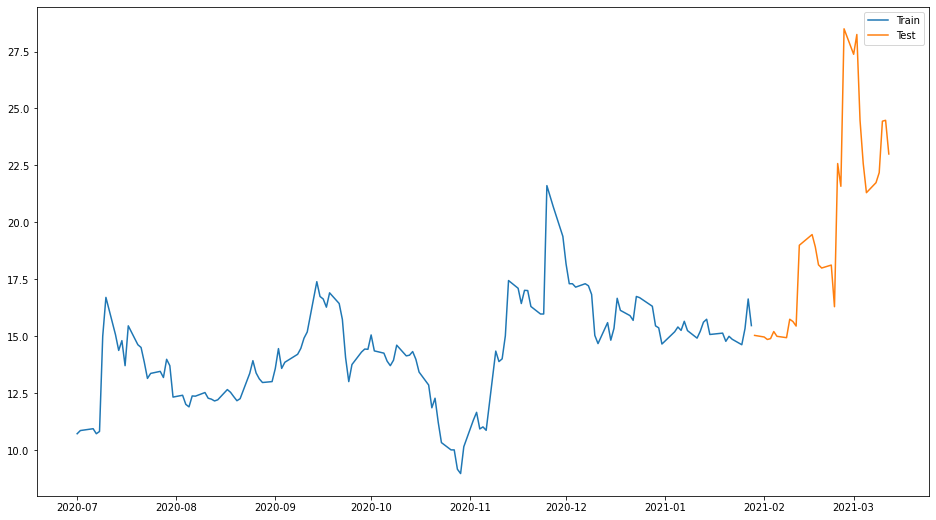

In [87]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [16,9]
plt.plot( train, label='Train')
plt.plot(test, label='Test')
#plt.plot(fitESautoPred, label='Automated grid search')
#plt.plot(forecast_custom_pred, label='Double Exponential Smoothing with custom grid search')
plt.legend(loc='best')
plt.show()

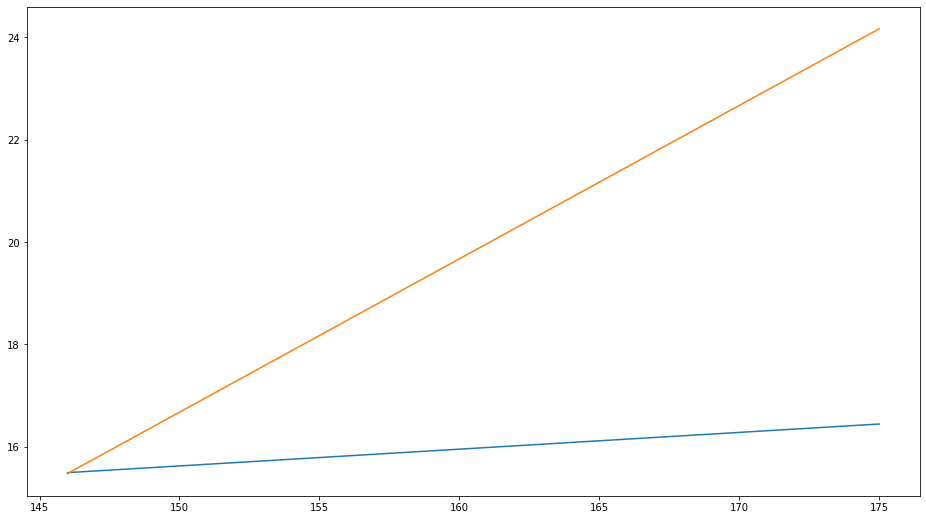

In [88]:
plt.plot(fitESautoPred, label='Automated grid search')
plt.plot(forecast_custom_pred, label='Double Exponential Smoothing with custom grid search')